# Tarea 3 Astroinformática
#### Benjamín Mancilla Vera

In [1]:
# Imports
import pickle
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, MinMaxInterval, SqrtStretch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import umap
from sklearn.preprocessing import LabelEncoder

2025-06-15 22:09:51.159946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750039791.181367   43465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750039791.187821   43465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750039791.205195   43465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750039791.205230   43465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750039791.205233   43465 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar crecimiento de memoria dinámico
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configurada: {len(gpus)} GPU(s) disponible(s)")
    except RuntimeError as e:
        print(f"Error configurando GPU: {e}")

✅ GPU configurada: 1 GPU(s) disponible(s)


## Parte 1

In [3]:
pkl_path = '2025A_AS4501_HW3.pkl'

with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

print("Tipo de objeto cargado:", type(data))

/tmp/ipykernel_43465/593815982.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


Tipo de objeto cargado: <class 'pandas.core.frame.DataFrame'>


In [4]:
print("Shape del DataFrame:", data.shape)
print("\nColumnas:")
print(data.columns.tolist())
print("\nPrimeras 5 filas:")
display(data.head())

df = data


Shape del DataFrame: (50345, 9)

Columnas:
['index', 'oid', 'candid', 'ra', 'dec', 'science', 'reference', 'diff', 'class']

Primeras 5 filas:


index           oid               candid          ra        dec  \
0     11  ZTF21aaebkmj  1501128131215015004   65.163495 -26.636435   
1     14  ZTF18abtnlik   643114394415015053  279.321654  49.148389   
2      9  ZTF19acjurot  1058126442015015014  320.853375 -17.720127   
3     15  ZTF20aanvpzo  1200441200215015003  224.375994   8.389928   
4     19  ZTF20aawxpru  1306411870015015009  322.840280   9.429956   

                                             science  \
0  [[404.2104, 394.65637, 403.2213, 391.0437, 396...   
1  [[79.67049, 86.467064, 78.972015, 81.246994, 8...   
2  [[113.59538, 131.67825, 126.9975, 119.60596, 1...   
3  [[161.64427, 161.45685, 166.97305, 155.20792, ...   
4  [[147.37575, 151.22055, 142.37598, 139.72981, ...   

                                           reference  \
0  [[387.88876, 388.28632, 390.10416, 391.13345, ...   
1  [[86.60097, 89.05083, 88.408226, 86.859764, 86...   
2  [[121.8025, 123.31801, 121.95386, 122.05768, 1...   
3  [[164.45232, 162.76022, 164.05763, 166.44301, ...   
4  [[148.13307, 144.70827, 142.08238, 140.17836, ...   

                                                diff    class  
0  [[15.940292, 8.174846, 11.953584, 0.73741037, ...  Unkwown  
1  [[-3.8708775, -6.8700647, -7.4733896, -4.98984...  Unkwown  
2  [[-9.240418, 11.035837, 4.2956905, -2.7166245,...  Unkwown  
3  [[-2.7969754, -1.3325354, 0.4744801, -8.980967...  Unkwown  
4  [[-2.9152439, 6.9139023, 0.40033725, 0.6607923...  Unkwown

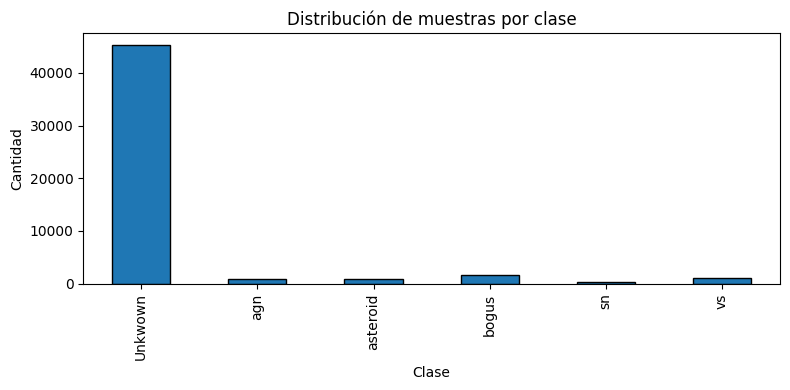

In [5]:
# Histrograma de la distribución de las clases
class_counts = df['class'].value_counts().sort_index()
plt.figure(figsize=(8,4))
class_counts.plot(kind='bar', edgecolor='black')
plt.title('Distribución de muestras por clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

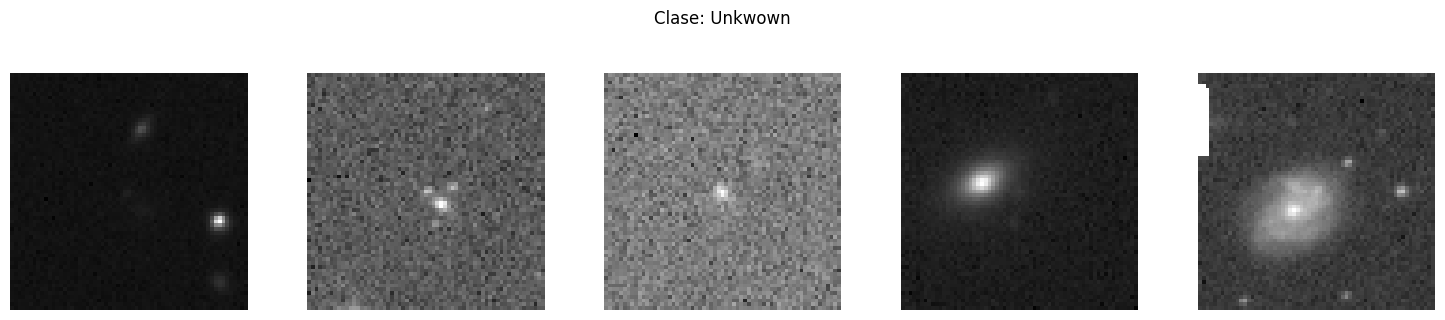

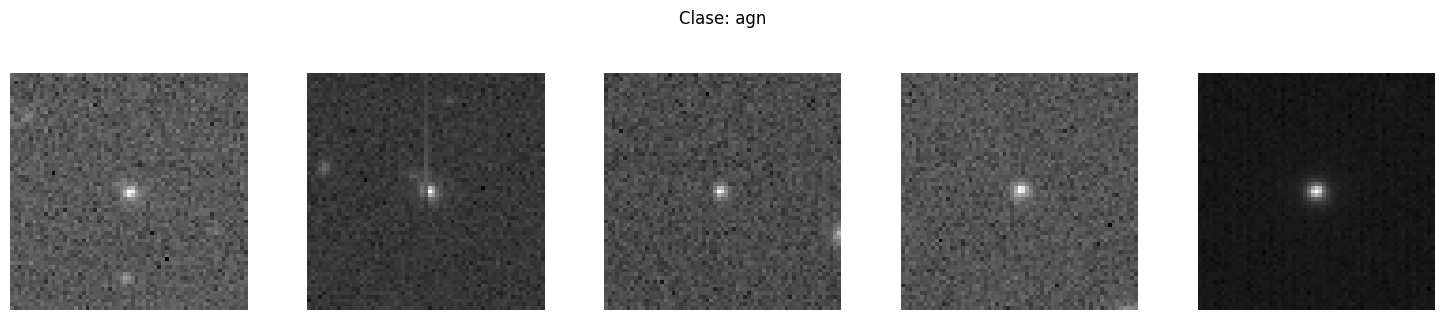

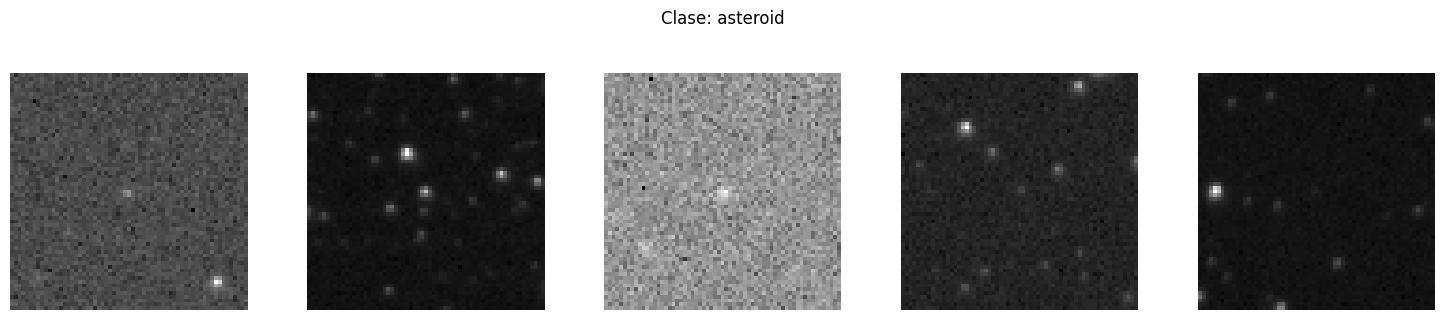

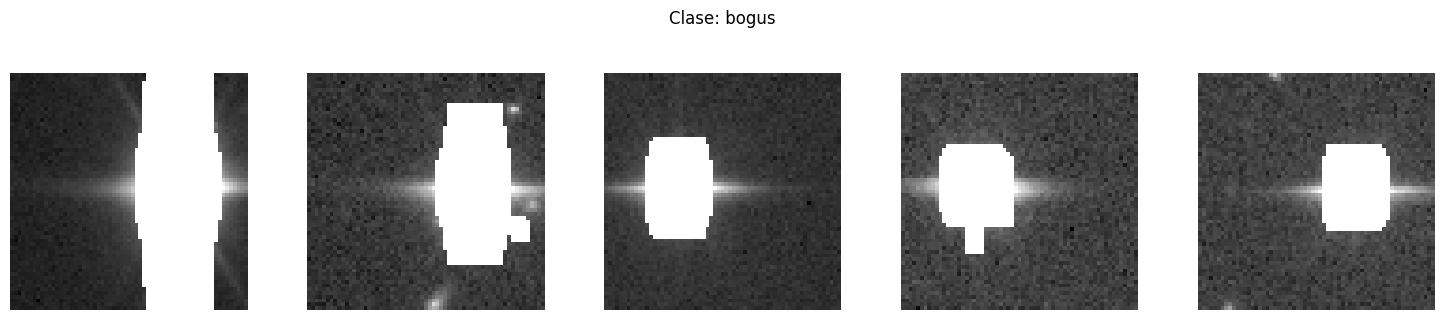

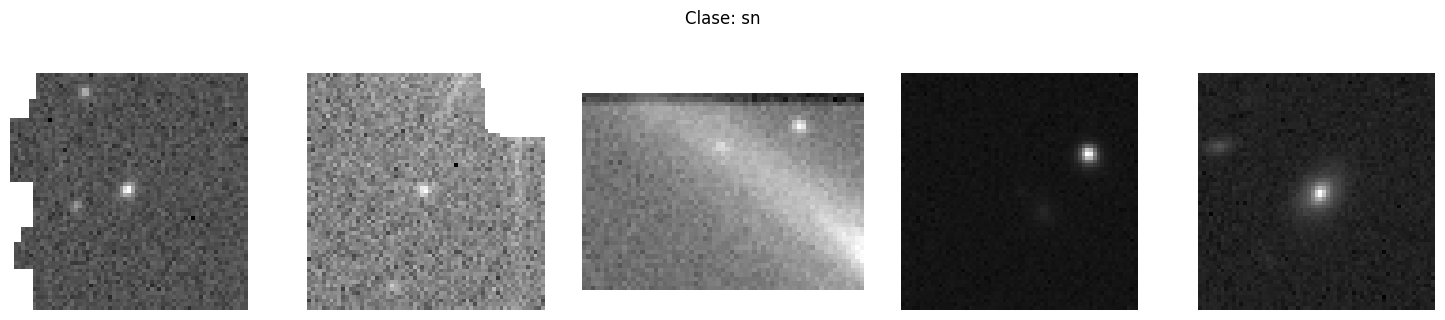

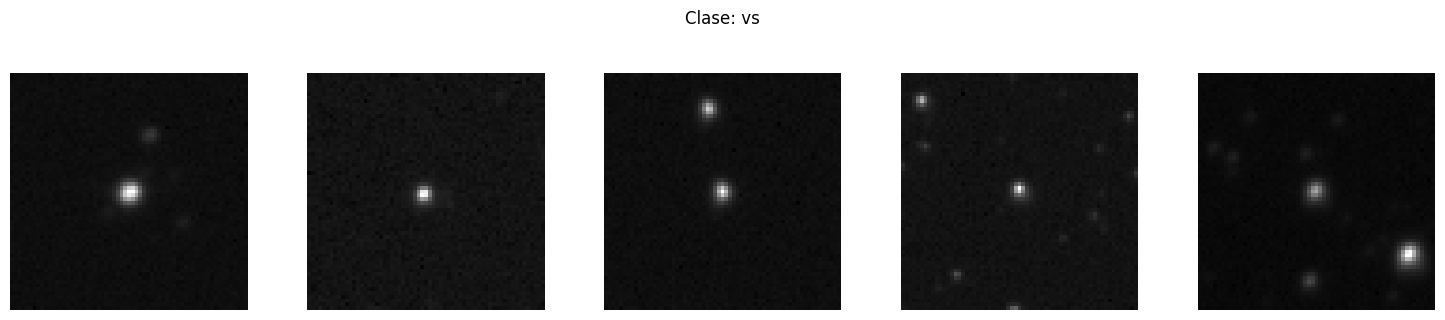

In [6]:
# Veamos 5 elementos por cada clase (normalizados)
for cls in class_counts.index:
    samples = df[df['class'] == cls].head(5)
    fig, axes = plt.subplots(1,5, figsize=(15,3))
    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = np.array(row['science'])
        norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=SqrtStretch())
        ax.imshow(img, norm=norm, cmap='gray')
        ax.axis('off')
    fig.suptitle(f'Clase: {cls}', y=1.05)
    plt.tight_layout()
    plt.show()

In [7]:
# Recortemos y centremos, ademas de normalizar las imagenes

def preprocess_with_astropy(img, crop_size=64):
    arr = np.array(img)
    h, w = arr.shape
    cy, cx = h//2, w//2
    half = crop_size//2
    crop = arr[cy-half:cy+half, cx-half:cx+half]
    norm = ImageNormalize(crop, interval=MinMaxInterval(), stretch=SqrtStretch())
    return norm(crop)

df['cropped'] = df['science'].apply(lambda x: preprocess_with_astropy(x, crop_size=40))

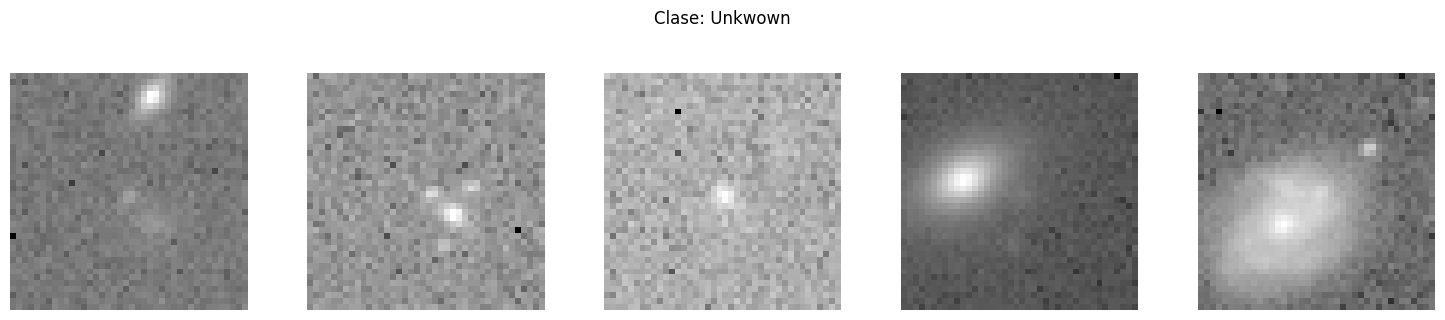

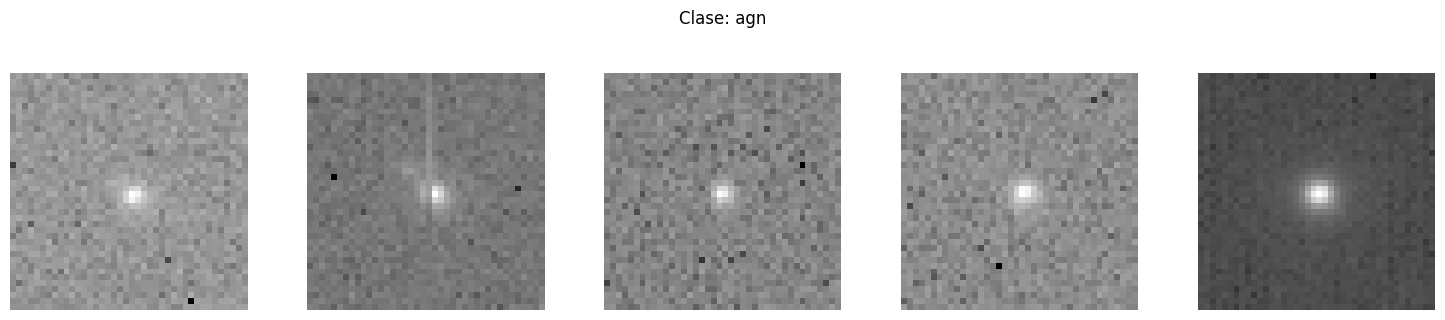

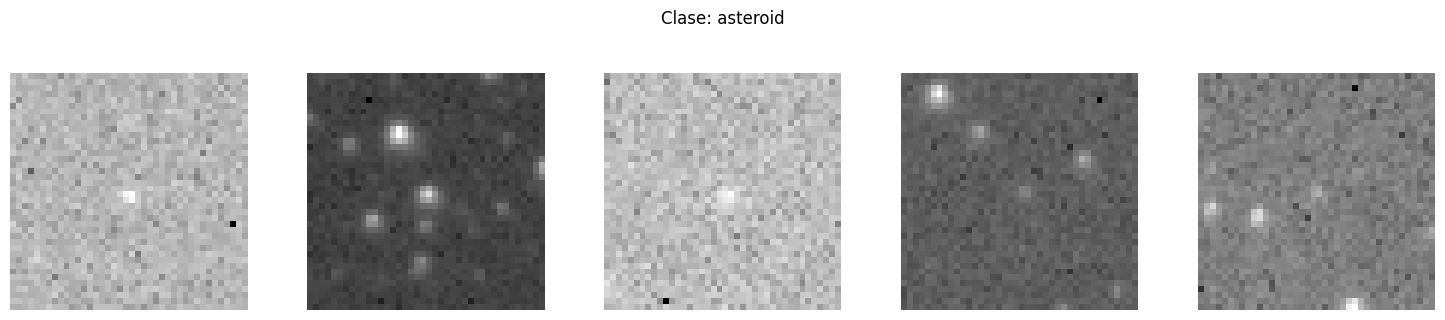

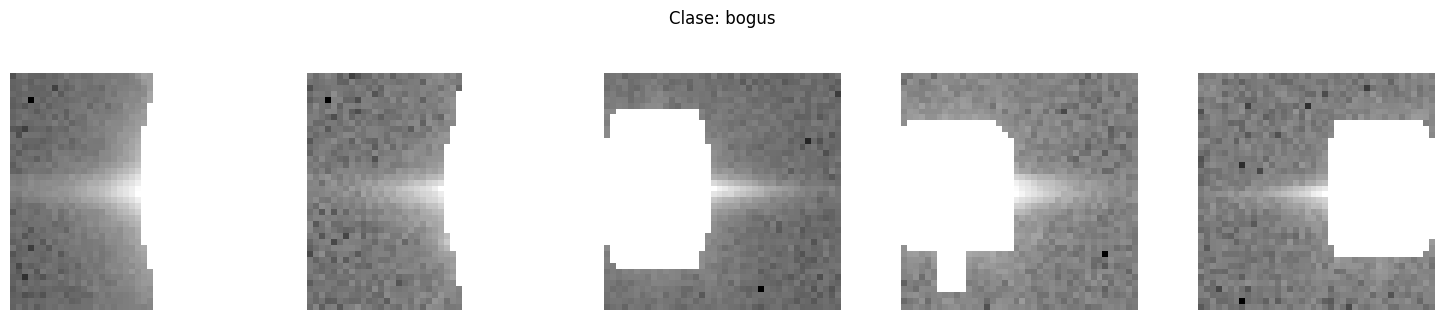

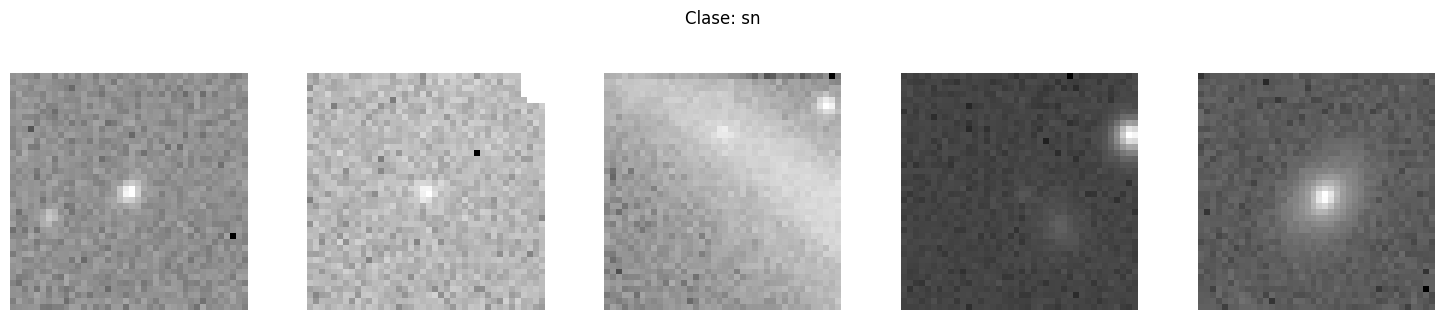

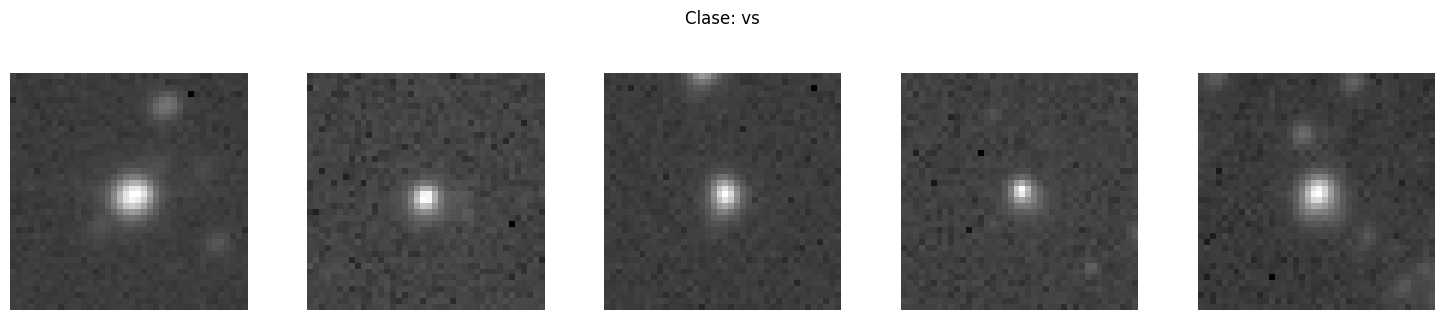

In [8]:
# Veamos 5 elementos por cada clase (normalizados)
for cls in class_counts.index:
    samples = df[df['class'] == cls].head(5)
    fig, axes = plt.subplots(1,5, figsize=(15,3))
    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = np.array(row['cropped'])
        norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=SqrtStretch())
        ax.imshow(img, norm=norm, cmap='gray')
        ax.axis('off')
    fig.suptitle(f'Clase: {cls}', y=1.05)
    plt.tight_layout()
    plt.show()

In [9]:
# Hacemos la division estratificada con k-fold = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)
df['fold'] = -1
for fold, (_, idx_val) in enumerate(skf.split(df, df['class'])):
    df.loc[idx_val, 'fold'] = fold

In [10]:
test_df = df[df['fold'] == 0]
rest_df = df[df['fold'] != 0]
train_df, val_df = train_test_split(
    rest_df, test_size=0.2,
    stratify=rest_df['class'],
    random_state=420
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 32220, Validation: 8056, Test: 10069


In [11]:
# Verificar que todas las imagenes esten normalizadas
def check_normalization(df):
    for idx, row in df.iterrows():
        img = row['cropped']
        if not np.isfinite(img).all() or img.min() < 0 or img.max() > 1:
            print(f"Imagen en el índice {idx} no está normalizada correctamente.")
            return False
    return True

if check_normalization(train_df) and check_normalization(val_df) and check_normalization(test_df):
    print("Todas las imágenes están normalizadas correctamente.")


Imagen en el índice 24467 no está normalizada correctamente.


In [12]:
def fix_image_dimensions(df, target_size=40):
    """Asegurar que todas las imágenes tengan el mismo tamaño"""
    fixed_images = []
    
    for idx, row in df.iterrows():
        img = np.array(row['cropped'])
        
        # Si la imagen no es del tamaño correcto, la redimensionamos
        if img.shape != (target_size, target_size):
            # Usar interpolación para redimensionar
            from scipy.ndimage import zoom
            
            # Calcular factores de escala
            zoom_factors = (target_size / img.shape[0], target_size / img.shape[1])
            img_resized = zoom(img, zoom_factors, order=1)  # order=1 para interpolación bilineal
            
            # Asegurar tamaño exacto (por si acaso hay errores de redondeo)
            if img_resized.shape != (target_size, target_size):
                # Recortar o rellenar si es necesario
                if img_resized.shape[0] > target_size:
                    img_resized = img_resized[:target_size, :]
                if img_resized.shape[1] > target_size:
                    img_resized = img_resized[:, :target_size]
                
                # Si es menor, rellenar con ceros
                if img_resized.shape[0] < target_size or img_resized.shape[1] < target_size:
                    temp = np.zeros((target_size, target_size))
                    temp[:img_resized.shape[0], :img_resized.shape[1]] = img_resized
                    img_resized = temp
            
            fixed_images.append(img_resized)
        else:
            fixed_images.append(img)
    
    return fixed_images

In [13]:
# Arreglar las dimensiones antes de continuar
print("Arreglando dimensiones de las imágenes...")
train_images_fixed = fix_image_dimensions(train_df)
val_images_fixed = fix_image_dimensions(val_df)

Arreglando dimensiones de las imágenes...


In [14]:
def prepare_data(train_images, val_images):
    X_train = np.stack(train_images)
    X_val = np.stack(val_images)
    
    # Expandir dimensiones para que sea (batch, height, width, channels)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    
    return X_train, X_val

In [15]:
X_train, X_val = prepare_data(train_images_fixed, val_images_fixed)
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")

Shape X_train: (32220, 40, 40, 1)
Shape X_val: (8056, 40, 40, 1)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU disponible: {len(gpus)} dispositivo(s)")
    except RuntimeError as e:
        print(e)
else:
    print("No se encontraron GPUs, usando CPU")

# Verificar dispositivo
with tf.device('/GPU:0' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else '/CPU:0'):
    print(f"Entrenando en: {tf.config.experimental.list_physical_devices('GPU')[0] if gpus else 'CPU'}")

### Parte 2

In [ ]:
# Definir el VAE corregido para imágenes 40x40
class VAE(keras.Model):
    def __init__(self, latent_dim=16, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        
        # Encoder para 40x40
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(40, 40, 1)), 
            layers.Conv2D(32, 3, strides=2, activation="relu", padding="same"), 
            layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"), 
            layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"), 
            layers.Flatten(), 
            layers.Dense(256, activation="relu")
        ])
        
        # Latent space
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        
        # Decoder para 40x40
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(5 * 5 * 128, activation="relu"), 
            layers.Reshape((5, 5, 128)),
            layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),  
            layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"), 
            layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")       
        ])
    
    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)
        return reconstructed, z_mean, z_log_var


In [18]:
# Función de pérdida VAE
def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.mse(
            tf.reshape(inputs, (tf.shape(inputs)[0], -1)),
            tf.reshape(reconstructed, (tf.shape(reconstructed)[0], -1))
        )
    )
    
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )
    
    return reconstruction_loss + 0.1 * kl_loss  # Beta = 0.1


In [19]:
# Crear y compilar el modelo
vae = VAE(latent_dim=16)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

/home/benjamin/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [20]:
# Entrenar el VAE
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        reconstructed, z_mean, z_log_var = vae(x_batch, training=True)
        loss = vae_loss(x_batch, reconstructed, z_mean, z_log_var)
    
    gradients = tape.gradient(loss, vae.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

@tf.function
def val_step(x_batch):
    reconstructed, z_mean, z_log_var = vae(x_batch, training=False)
    loss = vae_loss(x_batch, reconstructed, z_mean, z_log_var)
    return loss

In [21]:
def remove_nan_samples(X, y=None):
    """Eliminar todas las muestras que contengan NaN"""
    if len(X.shape) == 2:
        # Para datos 2D (muestras, features)
        valid_mask = ~np.any(np.isnan(X), axis=1)
    else:
        # Para otros formatos, aplanar y verificar
        valid_mask = ~np.any(np.isnan(X.reshape(X.shape[0], -1)), axis=1)
    
    X_clean = X[valid_mask]
    
    if y is not None:
        y_clean = y[valid_mask]
        print(f"Muestras eliminadas: {np.sum(~valid_mask)}")
        print(f"Muestras restantes: {X_clean.shape[0]}")
        return X_clean, y_clean
    else:
        print(f"Muestras eliminadas: {np.sum(~valid_mask)}")
        print(f"Muestras restantes: {X_clean.shape[0]}")
        return X_clean

In [22]:
# Eliminar muestras con NaN
X_train_clean, y_train_clean = remove_nan_samples(X_train, train_df['class'].values)
X_val_clean, y_val_clean = remove_nan_samples(X_val, val_df['class'].values)

Muestras eliminadas: 2894
Muestras restantes: 29326
Muestras eliminadas: 738
Muestras restantes: 7318


In [ ]:
with tf.device('/GPU:0'):
    
    epochs = 10
    batch_size = 16
    train_losses = []
    val_losses = []
    
    # Crear datasets optimizados para GPU
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train_clean)\
                      .batch(batch_size)\
                      .prefetch(tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_tensor_slices(X_val_clean)\
                    .batch(batch_size)\
                    .prefetch(tf.data.AUTOTUNE)
    
    print("Iniciando entrenamiento en GPU...")
    
    for epoch in range(epochs):
        # Training
        epoch_train_loss = []
        for batch in train_dataset:
            loss = train_step(batch) 
            epoch_train_loss.append(loss)
        
        # Validation
        epoch_val_loss = []
        for batch in val_dataset:
            loss = val_step(batch)  
            epoch_val_loss.append(loss)
        
        # Calcular perdidas 
        train_loss = tf.reduce_mean(epoch_train_loss)
        val_loss = tf.reduce_mean(epoch_val_loss)
        
        train_losses.append(train_loss.numpy())
        val_losses.append(val_loss.numpy())
        
        # Verificar NaN
        if tf.math.is_nan(train_loss) or tf.math.is_nan(val_loss):
            print(f"¡NaN detectado en época {epoch}!")
            break
            
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        if (epoch + 1) % 10 == 0:
            print(f"GPU Memory usage info available via nvidia-smi")

2025-06-15 22:10:11.947110: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375372800 exceeds 10% of free system memory.
2025-06-15 22:10:12.265343: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375372800 exceeds 10% of free system memory.


Iniciando entrenamiento en GPU...


2025-06-15 22:10:12.690878: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 375372800 exceeds 10% of free system memory.
I0000 00:00:1750039816.051794   43523 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-15 22:10:30.827220: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-15 22:10:32.624654: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10: Train Loss = 0.0303, Val Loss = 0.0309


2025-06-15 22:10:45.821017: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/10: Train Loss = 0.0297, Val Loss = 0.0306
Epoch 3/10: Train Loss = 0.0296, Val Loss = 0.0303


2025-06-15 22:11:13.331892: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/10: Train Loss = 0.0296, Val Loss = 0.0303
Epoch 5/10: Train Loss = 0.0296, Val Loss = 0.0302
Epoch 6/10: Train Loss = 0.0296, Val Loss = 0.0302
Epoch 7/10: Train Loss = 0.0296, Val Loss = 0.0301


2025-06-15 22:12:10.146511: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/10: Train Loss = 0.0296, Val Loss = 0.0301
Epoch 9/10: Train Loss = 0.0296, Val Loss = 0.0301
Epoch 10/10: Train Loss = 0.0296, Val Loss = 0.0301
GPU Memory usage info available via nvidia-smi


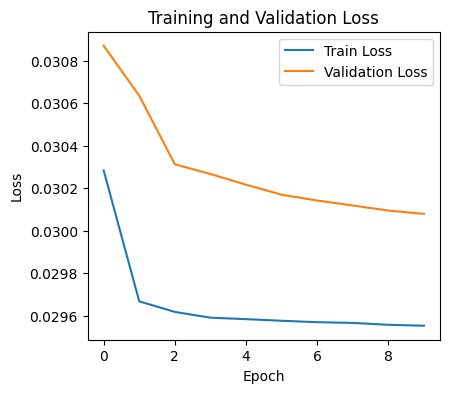

In [ ]:
# Graficar las losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

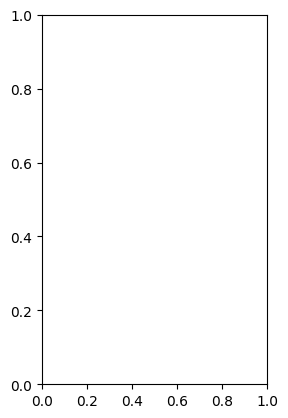

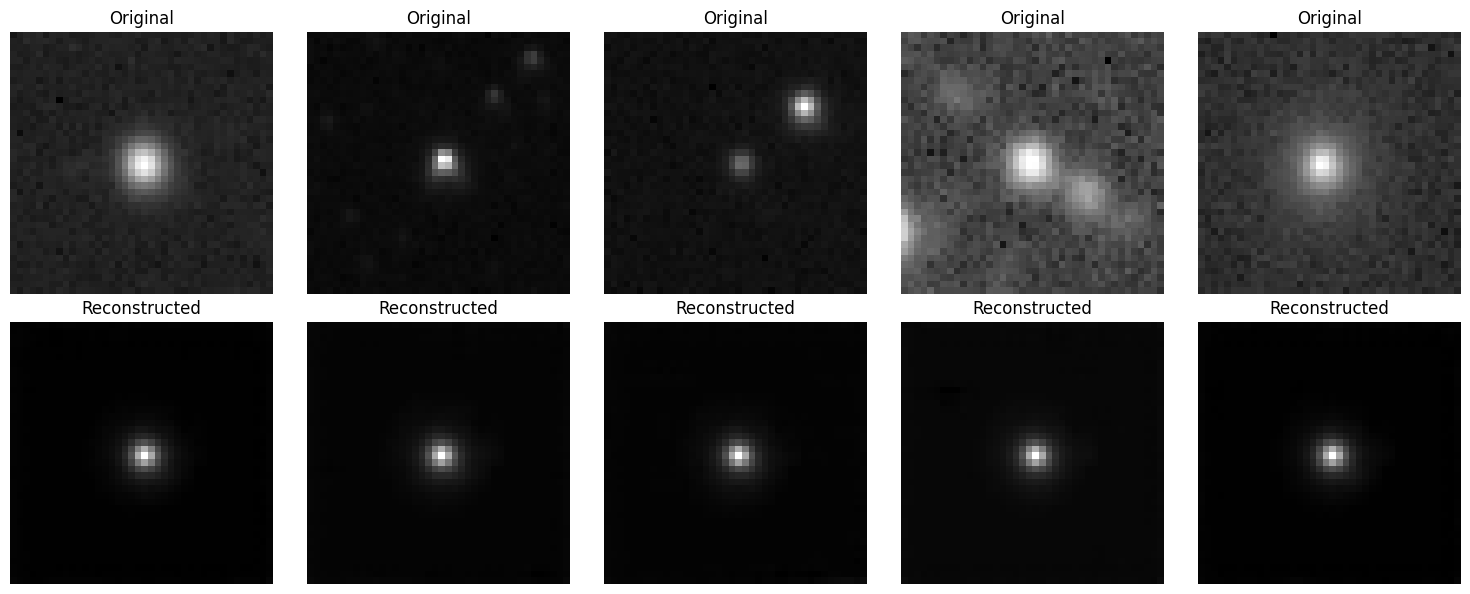

In [25]:
# Mostrar reconstrucciones
plt.subplot(1, 2, 2)
# Tomar algunas muestras de validación
sample_indices = np.random.choice(len(X_val), 5, replace=False)
samples = X_val[sample_indices]
reconstructed, _, _ = vae(samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original
    axes[0, i].imshow(samples[i, :, :, 0], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Reconstrucción
    axes[1, i].imshow(reconstructed[i, :, :, 0], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Visualizar el espacio latente con UMAP

# Usar solo los datos limpios que ya procesamos
X_all_clean = np.concatenate([X_train_clean, X_val_clean], axis=0)
y_all_clean = np.concatenate([y_train_clean, y_val_clean])

print(f"Total de muestras a procesar: {X_all_clean.shape[0]}")

# Procesar en lotes (si no me quedo sin memoria)
def encode_in_batches(vae, X, batch_size=32):
    """Codificar datos en lotes para evitar problemas de memoria"""
    z_means = []
    z_log_vars = []
    
    num_batches = int(np.ceil(len(X) / batch_size))
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X))
        
        batch = X[start_idx:end_idx]
        
        # Procesar lote
        with tf.device('/GPU:0'):
            z_mean_batch, z_log_var_batch = vae.encode(batch)
            z_means.append(z_mean_batch.numpy())
            z_log_vars.append(z_log_var_batch.numpy())
        
        # Mostrar progreso
        if (i + 1) % 50 == 0 or (i + 1) == num_batches:
            print(f"Procesado lote {i + 1}/{num_batches}")
    
    # Concatenar todos los resultados
    z_mean_all = np.concatenate(z_means, axis=0)
    z_log_var_all = np.concatenate(z_log_vars, axis=0)
    
    return z_mean_all, z_log_var_all



Total de muestras a procesar: 36644


Procesado lote 50/1146
Procesado lote 100/1146
Procesado lote 150/1146
Procesado lote 200/1146
Procesado lote 250/1146
Procesado lote 300/1146
Procesado lote 350/1146
Procesado lote 400/1146
Procesado lote 450/1146
Procesado lote 500/1146
Procesado lote 550/1146
Procesado lote 600/1146
Procesado lote 650/1146
Procesado lote 700/1146
Procesado lote 750/1146
Procesado lote 800/1146
Procesado lote 850/1146
Procesado lote 900/1146
Procesado lote 950/1146
Procesado lote 1000/1146
Procesado lote 1050/1146
Procesado lote 1100/1146
Procesado lote 1146/1146
Shape de representaciones latentes: (36644, 16)
Aplicando UMAP...


/home/benjamin/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/benjamin/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


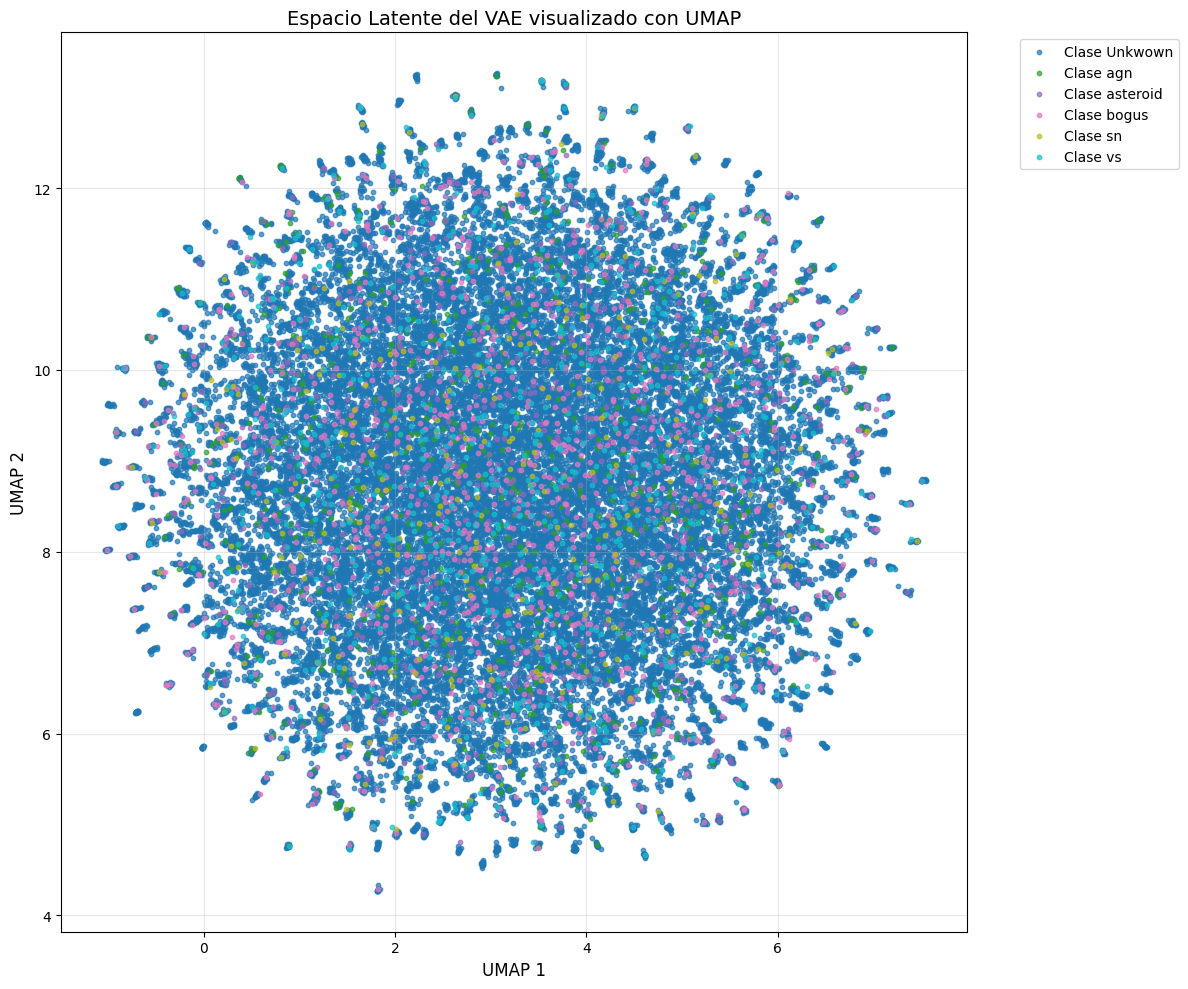


=== Estadísticas del Espacio Latente ===
Dimensión del espacio latente: 16
Rango de valores en el espacio latente:
  Min: -0.0003
  Max: 0.0002
  Mean: -0.0000
  Std: 0.0001

Distribución de muestras por clase:
  Clase Unkwown: 32975 muestras
  Clase agn: 738 muestras
  Clase asteroid: 717 muestras
  Clase bogus: 1116 muestras
  Clase sn: 298 muestras
  Clase vs: 800 muestras


In [ ]:
# Obtener representaciones latentes usando procesamiento por lotes
z_mean_all, z_log_var_all = encode_in_batches(vae, X_all_clean, batch_size=32)

print(f"Shape de representaciones latentes: {z_mean_all.shape}")

# Aplicar UMAP
print("Aplicando UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(z_mean_all)

# Graficar
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_all_clean))))

for i, cls in enumerate(sorted(np.unique(y_all_clean))):
    mask = y_all_clean == cls
    plt.scatter(embedding[mask, 0], embedding[mask, 1], 
                c=[colors[i]], label=f'Clase {cls}', alpha=0.7, s=10)

plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.title('Espacio Latente del VAE visualizado con UMAP', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stats
print("\n=== Estadísticas del Espacio Latente ===")
print(f"Dimensión del espacio latente: {z_mean_all.shape[1]}")
print(f"Rango de valores en el espacio latente:")
print(f"  Min: {z_mean_all.min():.4f}")
print(f"  Max: {z_mean_all.max():.4f}")
print(f"  Mean: {z_mean_all.mean():.4f}")
print(f"  Std: {z_mean_all.std():.4f}")

# Mostrar distribucion por clase
print(f"\nDistribución de muestras por clase:")
unique, counts = np.unique(y_all_clean, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count} muestras")

In [28]:
print(f"Dimensión del espacio latente: {vae.latent_dim}")
print(f"Loss final - Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")

Dimensión del espacio latente: 16
Loss final - Train: 0.0296, Val: 0.0301


### Parte 3

In [ ]:
class SemiSupervisedVAE(keras.Model):
    def __init__(self, latent_dim=16, num_classes=5, **kwargs):
        super(SemiSupervisedVAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder (igual que antes)
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(40, 40, 1)),
            layers.Conv2D(32, 3, strides=2, activation="relu", padding="same"),  # 40x40 -> 20x20
            layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"),  # 20x20 -> 10x10
            layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"), # 10x10 -> 5x5
            layers.Flatten(),  # 5x5x128 = 3200
            layers.Dense(256, activation="relu")
        ])
        
        # Latent space
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        
        # Decoder (igual que antes)
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(5 * 5 * 128, activation="relu"),
            layers.Reshape((5, 5, 128)),
            layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),  
            layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"), 
            layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")    
        ])
        
        # Clasificador desde el espacio latente
        self.classifier = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation="softmax")
        ])
    
    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        return self.decoder(z)
    
    def classify(self, z):
        return self.classifier(z)
    
    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)
        classification = self.classify(z)
        return reconstructed, classification, z_mean, z_log_var

In [30]:
def semisupervised_vae_loss(inputs, labels, reconstructed, classification, z_mean, z_log_var, 
                           labeled_mask, alpha=1.0, beta=0.1):
    """
    Pérdida combinada: reconstrucción + KL divergence + clasificación
    
    Args:
        inputs: imágenes de entrada
        labels: etiquetas verdaderas (solo para muestras etiquetadas)
        reconstructed: imágenes reconstruidas
        classification: predicciones de clasificación
        z_mean, z_log_var: parámetros del espacio latente
        labeled_mask: máscara booleana indicando cuáles muestras están etiquetadas
        alpha: peso para la pérdida de clasificación
        beta: peso para la pérdida KL
    """
    # Reconstruction loss (para todas las muestras)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.mse(
            tf.reshape(inputs, (tf.shape(inputs)[0], -1)),
            tf.reshape(reconstructed, (tf.shape(reconstructed)[0], -1))
        )
    )
    
    # KL divergence (para todas las muestras)
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )
    
    # Classification loss (solo para muestras etiquetadas)
    if tf.reduce_sum(tf.cast(labeled_mask, tf.float32)) > 0:
        # Filtrar solo las muestras etiquetadas
        labeled_predictions = tf.boolean_mask(classification, labeled_mask)
        labeled_true = tf.boolean_mask(labels, labeled_mask)
        
        classification_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(labeled_true, labeled_predictions)
        )
    else:
        classification_loss = 0.0
    
    total_loss = reconstruction_loss + beta * kl_loss + alpha * classification_loss
    
    return total_loss, reconstruction_loss, kl_loss, classification_loss


In [31]:
def prepare_semisupervised_data(X_train_clean, y_train_clean, X_val_clean, y_val_clean, 
                               labeled_fraction=0.1):
    """
    Simular un escenario semi-supervisado manteniendo solo una fracción de las etiquetas
    """
    # Para entrenamiento: mantener solo una fracción de etiquetas
    n_labeled_train = int(len(X_train_clean) * labeled_fraction)
    
    # Seleccionar índices de manera estratificada
    from sklearn.model_selection import train_test_split
    _, _, _, _, labeled_indices, _ = train_test_split(
        X_train_clean, y_train_clean, range(len(X_train_clean)),
        test_size=1-labeled_fraction, 
        stratify=y_train_clean, 
        random_state=42
    )
    
    # Crear máscaras
    train_labeled_mask = np.zeros(len(X_train_clean), dtype=bool)
    train_labeled_mask[labeled_indices] = True
    
    # Para validación: usar todas las etiquetas para evaluar
    val_labeled_mask = np.ones(len(X_val_clean), dtype=bool)
    
    print(f"Muestras de entrenamiento etiquetadas: {np.sum(train_labeled_mask)} / {len(X_train_clean)}")
    print(f"Muestras de validación etiquetadas: {np.sum(val_labeled_mask)} / {len(X_val_clean)}")
    
    return train_labeled_mask, val_labeled_mask

In [32]:
num_classes = len(np.unique(y_train_clean))
print(f"Número de clases: {num_classes}")

ss_vae = SemiSupervisedVAE(latent_dim=16, num_classes=num_classes)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Preparar datos semi-supervisados
train_labeled_mask, val_labeled_mask = prepare_semisupervised_data(
    X_train_clean, y_train_clean, X_val_clean, y_val_clean, labeled_fraction=0.1
)

Número de clases: 6


/home/benjamin/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Muestras de entrenamiento etiquetadas: 2932 / 29326
Muestras de validación etiquetadas: 7318 / 7318


In [33]:
@tf.function
def train_step_semisupervised(x_batch, y_batch, labeled_mask):
    with tf.GradientTape() as tape:
        reconstructed, classification, z_mean, z_log_var = ss_vae(x_batch, training=True)
        total_loss, recon_loss, kl_loss, class_loss = semisupervised_vae_loss(
            x_batch, y_batch, reconstructed, classification, z_mean, z_log_var, 
            labeled_mask, alpha=1.0, beta=0.1
        )
    
    gradients = tape.gradient(total_loss, ss_vae.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
    optimizer.apply_gradients(zip(gradients, ss_vae.trainable_variables))
    
    return total_loss, recon_loss, kl_loss, class_loss

@tf.function
def val_step_semisupervised(x_batch, y_batch, labeled_mask):
    reconstructed, classification, z_mean, z_log_var = ss_vae(x_batch, training=False)
    total_loss, recon_loss, kl_loss, class_loss = semisupervised_vae_loss(
        x_batch, y_batch, reconstructed, classification, z_mean, z_log_var, 
        labeled_mask, alpha=1.0, beta=0.1
    )
    
    # Calcular accuracy para muestras etiquetadas
    if tf.reduce_sum(tf.cast(labeled_mask, tf.float32)) > 0:
        labeled_predictions = tf.boolean_mask(classification, labeled_mask)
        labeled_true = tf.boolean_mask(y_batch, labeled_mask)
        accuracy = tf.reduce_mean(
            tf.cast(tf.equal(tf.argmax(labeled_predictions, axis=1), 
                           tf.cast(labeled_true, tf.int64)), tf.float32)
        )
    else:
        accuracy = 0.0
    
    return total_loss, recon_loss, kl_loss, class_loss, accuracy


In [ ]:
label_encoder = LabelEncoder()

# Ajustar el encoder con todas las etiquetas unicas (incluyendo 'Unknown', que a todo esto esta mal escrito)
all_labels = np.concatenate([y_train_clean, y_val_clean])
label_encoder.fit(all_labels)

# Convertir las etiquetas a enteros
y_train_encoded = label_encoder.transform(y_train_clean)
y_val_encoded = label_encoder.transform(y_val_clean)

print("Mapeo de etiquetas:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

print(f"Forma de y_train_encoded: {y_train_encoded.shape}")
print(f"Valores únicos: {np.unique(y_train_encoded)}")

Mapeo de etiquetas:
Unkwown -> 0
agn -> 1
asteroid -> 2
bogus -> 3
sn -> 4
vs -> 5
Forma de y_train_encoded: (29326,)
Valores únicos: [0 1 2 3 4 5]


In [ ]:
with tf.device('/GPU:0'):
    epochs = 20
    batch_size = 16
    
    train_total_losses = []
    train_recon_losses = []
    train_kl_losses = []
    train_class_losses = []
    
    val_total_losses = []
    val_recon_losses = []
    val_kl_losses = []
    val_class_losses = []
    val_accuracies = []
    
    print("Iniciando entrenamiento del VAE semi-supervisado...")
    
    for epoch in range(epochs):
        # Training
        epoch_train_total = []
        epoch_train_recon = []
        epoch_train_kl = []
        epoch_train_class = []
        
        # Crear batches manualmente para incluir las mascaras
        indices = np.arange(len(X_train_clean))
        np.random.shuffle(indices)
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = X_train_clean[batch_indices]
            y_batch = y_train_encoded[batch_indices]  
            mask_batch = train_labeled_mask[batch_indices]
            
            # Convertir a tensores
            x_batch = tf.constant(x_batch, dtype=tf.float32)
            y_batch = tf.constant(y_batch, dtype=tf.int32) 
            mask_batch = tf.constant(mask_batch, dtype=tf.bool)
            
            total_loss, recon_loss, kl_loss, class_loss = train_step_semisupervised(
                x_batch, y_batch, mask_batch
            )
            
            epoch_train_total.append(total_loss)
            epoch_train_recon.append(recon_loss)
            epoch_train_kl.append(kl_loss)
            epoch_train_class.append(class_loss)
        
        # Validation
        epoch_val_total = []
        epoch_val_recon = []
        epoch_val_kl = []
        epoch_val_class = []
        epoch_val_acc = []
        
        val_indices = np.arange(len(X_val_clean))
        for i in range(0, len(val_indices), batch_size):
            batch_indices = val_indices[i:i+batch_size]
            x_batch = X_val_clean[batch_indices]
            y_batch = y_val_encoded[batch_indices] 
            mask_batch = val_labeled_mask[batch_indices]
            
            # Convertir a tensores
            x_batch = tf.constant(x_batch, dtype=tf.float32)
            y_batch = tf.constant(y_batch, dtype=tf.int32)
            mask_batch = tf.constant(mask_batch, dtype=tf.bool)
            
            total_loss, recon_loss, kl_loss, class_loss, accuracy = val_step_semisupervised(
                x_batch, y_batch, mask_batch
            )
            
            epoch_val_total.append(total_loss)
            epoch_val_recon.append(recon_loss)
            epoch_val_kl.append(kl_loss)
            epoch_val_class.append(class_loss)
            epoch_val_acc.append(accuracy)
        
        # Calcular promedios
        train_total_loss = tf.reduce_mean(epoch_train_total)
        train_recon_loss = tf.reduce_mean(epoch_train_recon)
        train_kl_loss = tf.reduce_mean(epoch_train_kl)
        train_class_loss = tf.reduce_mean(epoch_train_class)
        
        val_total_loss = tf.reduce_mean(epoch_val_total)
        val_recon_loss = tf.reduce_mean(epoch_val_recon)
        val_kl_loss = tf.reduce_mean(epoch_val_kl)
        val_class_loss = tf.reduce_mean(epoch_val_class)
        val_accuracy = tf.reduce_mean(epoch_val_acc)
        
        # Guardar metricas
        train_total_losses.append(train_total_loss.numpy())
        train_recon_losses.append(train_recon_loss.numpy())
        train_kl_losses.append(train_kl_loss.numpy())
        train_class_losses.append(train_class_loss.numpy())
        
        val_total_losses.append(val_total_loss.numpy())
        val_recon_losses.append(val_recon_loss.numpy())
        val_kl_losses.append(val_kl_loss.numpy())
        val_class_losses.append(val_class_loss.numpy())
        val_accuracies.append(val_accuracy.numpy())
        
        # Verificar NaN
        if (tf.math.is_nan(train_total_loss) or tf.math.is_nan(val_total_loss)):
            print(f"¡NaN detectado en época {epoch}!")
            break
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train - Total: {train_total_loss:.4f}, Recon: {train_recon_loss:.4f}, "
              f"KL: {train_kl_loss:.4f}, Class: {train_class_loss:.4f}")
        print(f"  Val   - Total: {val_total_loss:.4f}, Recon: {val_recon_loss:.4f}, "
              f"KL: {val_kl_loss:.4f}, Class: {val_class_loss:.4f}, Acc: {val_accuracy:.4f}")

print("Entrenamiento completado!")

Iniciando entrenamiento del VAE semi-supervisado...
Epoch 1/20:
  Train - Total: 0.6103, Recon: 0.0304, KL: 0.1304, Class: 0.5669
  Val   - Total: 0.7655, Recon: 0.0300, KL: 0.0993, Class: 0.7255, Acc: 0.8997
Epoch 2/20:
  Train - Total: 0.7082, Recon: 0.0297, KL: 0.1398, Class: 0.6645
  Val   - Total: 0.7995, Recon: 0.0303, KL: 0.1722, Class: 0.7520, Acc: 0.8989
Epoch 3/20:
  Train - Total: 0.8106, Recon: 0.0296, KL: 0.1380, Class: 0.7671
  Val   - Total: 0.9372, Recon: 0.0300, KL: 0.1292, Class: 0.8942, Acc: 0.8981
Epoch 4/20:
  Train - Total: 0.8514, Recon: 0.0296, KL: 0.1137, Class: 0.8104
  Val   - Total: 0.9169, Recon: 0.0300, KL: 0.1017, Class: 0.8767, Acc: 0.8929
Epoch 5/20:
  Train - Total: 0.8811, Recon: 0.0296, KL: 0.0933, Class: 0.8422
  Val   - Total: 1.1296, Recon: 0.0300, KL: 0.0862, Class: 1.0910, Acc: 0.8980
Epoch 6/20:
  Train - Total: 0.8519, Recon: 0.0296, KL: 0.0782, Class: 0.8145
  Val   - Total: 1.1569, Recon: 0.0300, KL: 0.0631, Class: 1.1206, Acc: 0.8957
Epoch 

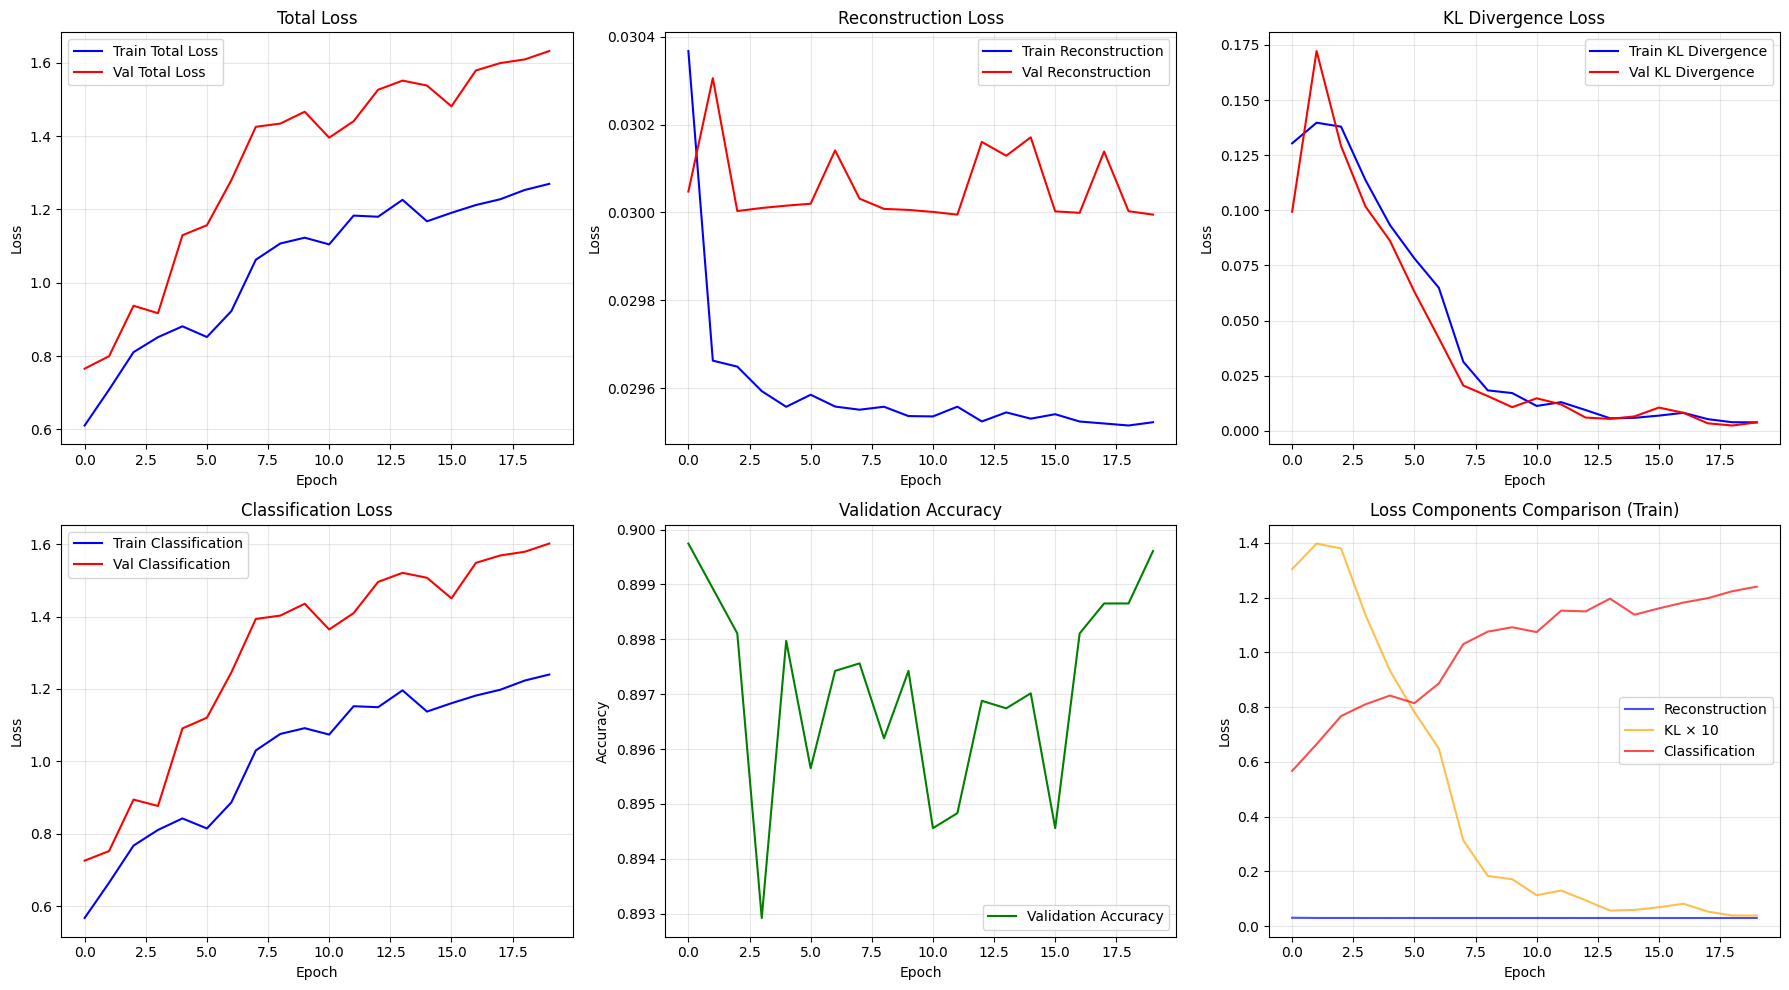

In [36]:
# Graficar las pérdidas y métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Pérdida total
axes[0, 0].plot(train_total_losses, label='Train Total Loss', color='blue')
axes[0, 0].plot(val_total_losses, label='Val Total Loss', color='red')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Pérdida de reconstrucción
axes[0, 1].plot(train_recon_losses, label='Train Reconstruction', color='blue')
axes[0, 1].plot(val_recon_losses, label='Val Reconstruction', color='red')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Pérdida KL
axes[0, 2].plot(train_kl_losses, label='Train KL Divergence', color='blue')
axes[0, 2].plot(val_kl_losses, label='Val KL Divergence', color='red')
axes[0, 2].set_title('KL Divergence Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Pérdida de clasificación
axes[1, 0].plot(train_class_losses, label='Train Classification', color='blue')
axes[1, 0].plot(val_class_losses, label='Val Classification', color='red')
axes[1, 0].set_title('Classification Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy de validación
axes[1, 1].plot(val_accuracies, label='Validation Accuracy', color='green')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Comparación de pérdidas
axes[1, 2].plot(train_recon_losses, label='Reconstruction', color='blue', alpha=0.7)
axes[1, 2].plot([x*10 for x in train_kl_losses], label='KL × 10', color='orange', alpha=0.7)
axes[1, 2].plot(train_class_losses, label='Classification', color='red', alpha=0.7)
axes[1, 2].set_title('Loss Components Comparison (Train)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

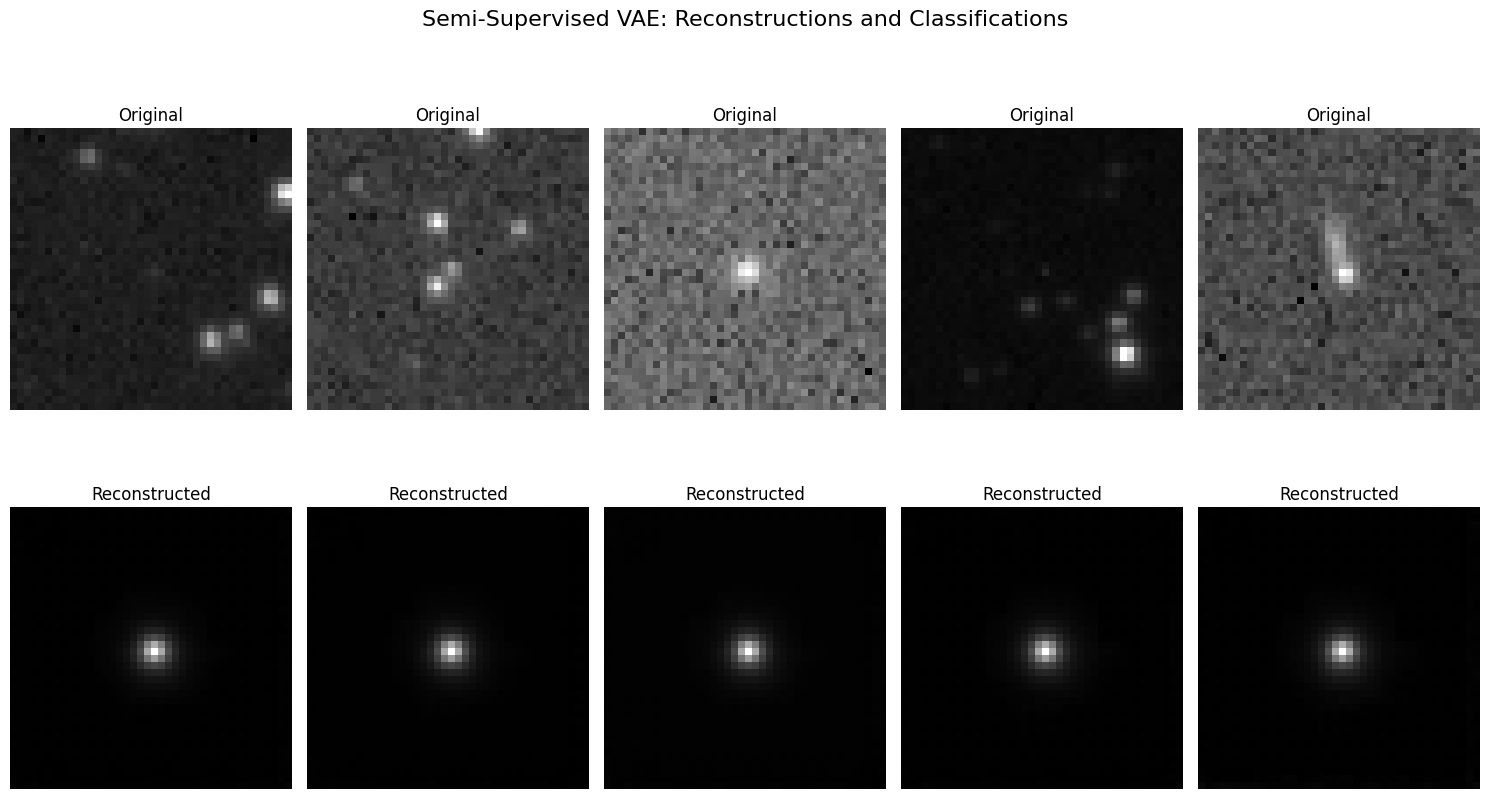

In [39]:
# Mostrar reconstrucciones del modelo semi-supervisado
sample_indices = np.random.choice(len(X_val_clean), 5, replace=False)
samples = X_val_clean[sample_indices]
reconstructed, classifications, _, _ = ss_vae(samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 9))
for i in range(5):
    # Original
    axes[0, i].imshow(samples[i, :, :, 0], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Reconstrucción
    axes[1, i].imshow(reconstructed[i, :, :, 0], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')
    

plt.suptitle('Semi-Supervised VAE: Reconstructions and Classifications', fontsize=16)
plt.tight_layout()
plt.show()

Procesado lote 50/1146
Procesado lote 100/1146
Procesado lote 150/1146
Procesado lote 200/1146
Procesado lote 250/1146
Procesado lote 300/1146
Procesado lote 350/1146
Procesado lote 400/1146
Procesado lote 450/1146
Procesado lote 500/1146
Procesado lote 550/1146
Procesado lote 600/1146
Procesado lote 650/1146
Procesado lote 700/1146
Procesado lote 750/1146
Procesado lote 800/1146
Procesado lote 850/1146
Procesado lote 900/1146
Procesado lote 950/1146
Procesado lote 1000/1146
Procesado lote 1050/1146
Procesado lote 1100/1146
Procesado lote 1146/1146
Aplicando UMAP al espacio latente del modelo semi-supervisado...


/home/benjamin/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/benjamin/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


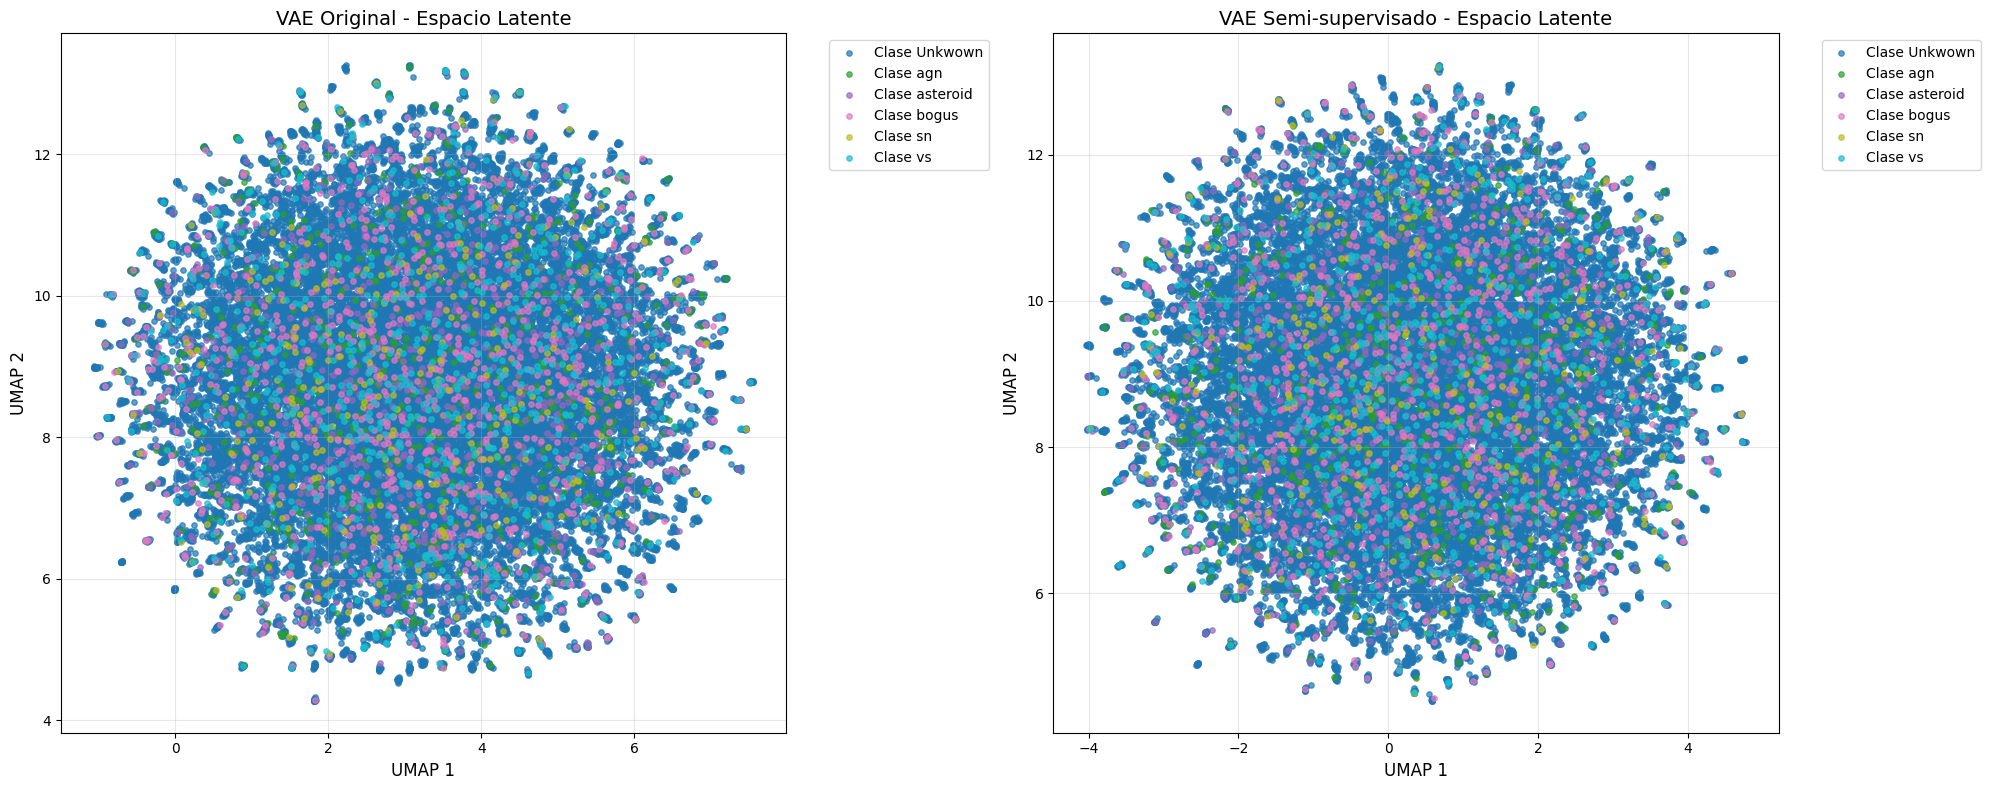

In [40]:
def encode_semisupervised_in_batches(model, X, batch_size=32):
    """Codificar datos con el modelo semi-supervisado en lotes"""
    z_means = []
    z_log_vars = []
    classifications = []
    
    num_batches = int(np.ceil(len(X) / batch_size))
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X))
        
        batch = X[start_idx:end_idx]
        
        with tf.device('/GPU:0'):
            z_mean_batch, z_log_var_batch = model.encode(batch)
            _, class_batch, _, _ = model(batch)
            
            z_means.append(z_mean_batch.numpy())
            z_log_vars.append(z_log_var_batch.numpy())
            classifications.append(class_batch.numpy())
        
        if (i + 1) % 50 == 0 or (i + 1) == num_batches:
            print(f"Procesado lote {i + 1}/{num_batches}")
    
    z_mean_all = np.concatenate(z_means, axis=0)
    z_log_var_all = np.concatenate(z_log_vars, axis=0)
    classifications_all = np.concatenate(classifications, axis=0)
    
    return z_mean_all, z_log_var_all, classifications_all

# Obtener representaciones del modelo semi-supervisado
z_mean_ss, z_log_var_ss, classifications_ss = encode_semisupervised_in_batches(ss_vae, X_all_clean)

print("Aplicando UMAP al espacio latente del modelo semi-supervisado...")
reducer_ss = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_ss = reducer_ss.fit_transform(z_mean_ss)

# Comparar visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# VAE original
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_all_clean))))
for i, cls in enumerate(sorted(np.unique(y_all_clean))):
    mask = y_all_clean == cls
    axes[0].scatter(embedding[mask, 0], embedding[mask, 1], 
                   c=[colors[i]], label=f'Clase {cls}', alpha=0.7, s=15)

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].set_title('VAE Original - Espacio Latente', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# VAE semi-supervisado
for i, cls in enumerate(sorted(np.unique(y_all_clean))):
    mask = y_all_clean == cls
    axes[1].scatter(embedding_ss[mask, 0], embedding_ss[mask, 1], 
                   c=[colors[i]], label=f'Clase {cls}', alpha=0.7, s=15)

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].set_title('VAE Semi-supervisado - Espacio Latente', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

No se puede apreciar un gran cambio en el UMAP final, pero si en las metricas de entrenamiento. Por lo menos mi implementacion de semisupervisada empeora el entrenamiento, teniendo errores mayores y una convergencia peor.

### Parte 4

In [44]:
print("Filtrando dataset para eliminar la clase 'Unknown'...")
labeled_only_df = df[df['class'] != 'Unkwown'].copy()

print(f"Dataset original: {len(df)} muestras")
print(f"Dataset solo etiquetado: {len(labeled_only_df)} muestras")
print("\nDistribución de clases después del filtrado:")
print(labeled_only_df['class'].value_counts().sort_index())

Filtrando dataset para eliminar la clase 'Unknown'...
Dataset original: 50345 muestras
Dataset solo etiquetado: 5035 muestras

Distribución de clases después del filtrado:
class
agn          971
asteroid     942
bogus       1658
sn           388
vs          1076
Name: count, dtype: int64


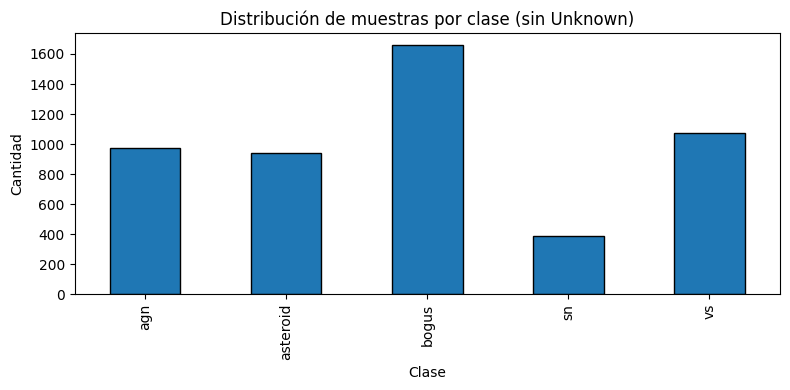

In [45]:
class_counts_labeled = labeled_only_df['class'].value_counts().sort_index()
plt.figure(figsize=(8,4))
class_counts_labeled.plot(kind='bar', edgecolor='black')
plt.title('Distribución de muestras por clase (sin Unknown)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

In [46]:
skf_labeled = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)
labeled_only_df['fold'] = -1
for fold, (_, idx_val) in enumerate(skf_labeled.split(labeled_only_df, labeled_only_df['class'])):
    labeled_only_df.loc[labeled_only_df.index[idx_val], 'fold'] = fold

In [48]:
test_df_labeled = labeled_only_df[labeled_only_df['fold'] == 0]
rest_df_labeled = labeled_only_df[labeled_only_df['fold'] != 0]
train_df_labeled, val_df_labeled = train_test_split(
    rest_df_labeled, test_size=0.2,
    stratify=rest_df_labeled['class'],
    random_state=420
)

print(f"Train: {len(train_df_labeled)}, Validation: {len(val_df_labeled)}, Test: {len(test_df_labeled)}")


Train: 3222, Validation: 806, Test: 1007


In [49]:
# Preparar las imágenes
train_images_labeled_fixed = fix_image_dimensions(train_df_labeled)
val_images_labeled_fixed = fix_image_dimensions(val_df_labeled)

X_train_labeled, X_val_labeled = prepare_data(train_images_labeled_fixed, val_images_labeled_fixed)
print(f"Shape X_train_labeled: {X_train_labeled.shape}")
print(f"Shape X_val_labeled: {X_val_labeled.shape}")


Shape X_train_labeled: (3222, 40, 40, 1)
Shape X_val_labeled: (806, 40, 40, 1)


In [50]:
X_train_labeled_clean, y_train_labeled_clean = remove_nan_samples(X_train_labeled, train_df_labeled['class'].values)
X_val_labeled_clean, y_val_labeled_clean = remove_nan_samples(X_val_labeled, val_df_labeled['class'].values)

label_encoder_labeled = LabelEncoder()
all_labels_labeled = np.concatenate([y_train_labeled_clean, y_val_labeled_clean])
label_encoder_labeled.fit(all_labels_labeled)

y_train_labeled_encoded = label_encoder_labeled.transform(y_train_labeled_clean)
y_val_labeled_encoded = label_encoder_labeled.transform(y_val_labeled_clean)

Muestras eliminadas: 277
Muestras restantes: 2945
Muestras eliminadas: 77
Muestras restantes: 729


In [51]:
print("Mapeo de etiquetas (solo datos etiquetados):")
for i, label in enumerate(label_encoder_labeled.classes_):
    print(f"{label} -> {i}")

num_classes_labeled = len(np.unique(y_train_labeled_encoded))
print(f"Número de clases (sin Unknown): {num_classes_labeled}")

Mapeo de etiquetas (solo datos etiquetados):
agn -> 0
asteroid -> 1
bogus -> 2
sn -> 3
vs -> 4
Número de clases (sin Unknown): 5


In [52]:
ss_vae_labeled = SemiSupervisedVAE(latent_dim=16, num_classes=num_classes_labeled)
optimizer_labeled = keras.optimizers.Adam(learning_rate=1e-3)


/home/benjamin/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [56]:
train_labeled_mask_all = np.ones(len(X_train_labeled_clean), dtype=bool)
val_labeled_mask_all = np.ones(len(X_val_labeled_clean), dtype=bool)

print(f"Muestras de entrenamiento etiquetadas: {np.sum(train_labeled_mask_all)} / {len(X_train_labeled_clean)}")
print(f"Muestras de validación etiquetadas: {np.sum(val_labeled_mask_all)} / {len(X_val_labeled_clean)}")

Muestras de entrenamiento etiquetadas: 2945 / 2945
Muestras de validación etiquetadas: 729 / 729


In [57]:
with tf.device('/GPU:0'):
    epochs = 20
    batch_size = 16
    
    # Listas para almacenar métricas
    train_total_losses_labeled = []
    train_recon_losses_labeled = []
    train_kl_losses_labeled = []
    train_class_losses_labeled = []
    
    val_total_losses_labeled = []
    val_recon_losses_labeled = []
    val_kl_losses_labeled = []
    val_class_losses_labeled = []
    val_accuracies_labeled = []
    
    print("Iniciando entrenamiento del VAE semi-supervisado (solo datos etiquetados)...")
    
    for epoch in range(epochs):
        # Training
        epoch_train_total = []
        epoch_train_recon = []
        epoch_train_kl = []
        epoch_train_class = []
        
        # Crear batches manualmente para incluir las máscaras
        indices = np.arange(len(X_train_labeled_clean))
        np.random.shuffle(indices)
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = X_train_labeled_clean[batch_indices]
            y_batch = y_train_labeled_encoded[batch_indices]
            mask_batch = train_labeled_mask_all[batch_indices]
            
            # Convertir a tensores
            x_batch = tf.constant(x_batch, dtype=tf.float32)
            y_batch = tf.constant(y_batch, dtype=tf.int32)
            mask_batch = tf.constant(mask_batch, dtype=tf.bool)
            
            with tf.GradientTape() as tape:
                reconstructed, classification, z_mean, z_log_var = ss_vae_labeled(x_batch, training=True)
                total_loss, recon_loss, kl_loss, class_loss = semisupervised_vae_loss(
                    x_batch, y_batch, reconstructed, classification, z_mean, z_log_var, 
                    mask_batch, alpha=1.0, beta=0.1
                )
            
            gradients = tape.gradient(total_loss, ss_vae_labeled.trainable_variables)
            gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
            optimizer_labeled.apply_gradients(zip(gradients, ss_vae_labeled.trainable_variables))
            
            epoch_train_total.append(total_loss)
            epoch_train_recon.append(recon_loss)
            epoch_train_kl.append(kl_loss)
            epoch_train_class.append(class_loss)
        
        # Validation
        epoch_val_total = []
        epoch_val_recon = []
        epoch_val_kl = []
        epoch_val_class = []
        epoch_val_acc = []
        
        val_indices = np.arange(len(X_val_labeled_clean))
        for i in range(0, len(val_indices), batch_size):
            batch_indices = val_indices[i:i+batch_size]
            x_batch = X_val_labeled_clean[batch_indices]
            y_batch = y_val_labeled_encoded[batch_indices]
            mask_batch = val_labeled_mask_all[batch_indices]
            
            # Convertir a tensores
            x_batch = tf.constant(x_batch, dtype=tf.float32)
            y_batch = tf.constant(y_batch, dtype=tf.int32)
            mask_batch = tf.constant(mask_batch, dtype=tf.bool)
            
            reconstructed, classification, z_mean, z_log_var = ss_vae_labeled(x_batch, training=False)
            total_loss, recon_loss, kl_loss, class_loss = semisupervised_vae_loss(
                x_batch, y_batch, reconstructed, classification, z_mean, z_log_var, 
                mask_batch, alpha=1.0, beta=0.1
            )
            
            # Calcular accuracy para muestras etiquetadas
            accuracy = tf.reduce_mean(
                tf.cast(tf.equal(tf.argmax(classification, axis=1), 
                               tf.cast(y_batch, tf.int64)), tf.float32)
            )
            
            epoch_val_total.append(total_loss)
            epoch_val_recon.append(recon_loss)
            epoch_val_kl.append(kl_loss)
            epoch_val_class.append(class_loss)
            epoch_val_acc.append(accuracy)
        
        # Calcular promedios
        train_total_loss = tf.reduce_mean(epoch_train_total)
        train_recon_loss = tf.reduce_mean(epoch_train_recon)
        train_kl_loss = tf.reduce_mean(epoch_train_kl)
        train_class_loss = tf.reduce_mean(epoch_train_class)
        
        val_total_loss = tf.reduce_mean(epoch_val_total)
        val_recon_loss = tf.reduce_mean(epoch_val_recon)
        val_kl_loss = tf.reduce_mean(epoch_val_kl)
        val_class_loss = tf.reduce_mean(epoch_val_class)
        val_accuracy = tf.reduce_mean(epoch_val_acc)
        
        # Guardar métricas
        train_total_losses_labeled.append(train_total_loss.numpy())
        train_recon_losses_labeled.append(train_recon_loss.numpy())
        train_kl_losses_labeled.append(train_kl_loss.numpy())
        train_class_losses_labeled.append(train_class_loss.numpy())
        
        val_total_losses_labeled.append(val_total_loss.numpy())
        val_recon_losses_labeled.append(val_recon_loss.numpy())
        val_kl_losses_labeled.append(val_kl_loss.numpy())
        val_class_losses_labeled.append(val_class_loss.numpy())
        val_accuracies_labeled.append(val_accuracy.numpy())
        
        # Verificar NaN
        if (tf.math.is_nan(train_total_loss) or tf.math.is_nan(val_total_loss)):
            print(f"¡NaN detectado en época {epoch}!")
            break
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train - Total: {train_total_loss:.4f}, Recon: {train_recon_loss:.4f}, "
              f"KL: {train_kl_loss:.4f}, Class: {train_class_loss:.4f}")
        print(f"  Val   - Total: {val_total_loss:.4f}, Recon: {val_recon_loss:.4f}, "
              f"KL: {val_kl_loss:.4f}, Class: {val_class_loss:.4f}, Acc: {val_accuracy:.4f}")

print("Entrenamiento completado (solo datos etiquetados)!")

Iniciando entrenamiento del VAE semi-supervisado (solo datos etiquetados)...
Epoch 1/20:
  Train - Total: 1.6585, Recon: 0.0323, KL: 0.1631, Class: 1.6099
  Val   - Total: 1.5641, Recon: 0.0257, KL: 0.2720, Class: 1.5112, Acc: 0.3241
Epoch 2/20:
  Train - Total: 1.5588, Recon: 0.0252, KL: 0.5652, Class: 1.4771
  Val   - Total: 1.4868, Recon: 0.0221, KL: 0.7351, Class: 1.3913, Acc: 0.3986
Epoch 3/20:
  Train - Total: 1.4919, Recon: 0.0246, KL: 0.8915, Class: 1.3781
  Val   - Total: 1.4362, Recon: 0.0268, KL: 0.9848, Class: 1.3110, Acc: 0.4325
Epoch 4/20:
  Train - Total: 1.4288, Recon: 0.0232, KL: 1.2547, Class: 1.2801
  Val   - Total: 1.3775, Recon: 0.0217, KL: 1.1927, Class: 1.2365, Acc: 0.4855
Epoch 5/20:
  Train - Total: 1.4042, Recon: 0.0227, KL: 1.4742, Class: 1.2340
  Val   - Total: 1.3190, Recon: 0.0226, KL: 1.3796, Class: 1.1585, Acc: 0.5239
Epoch 6/20:
  Train - Total: 1.3339, Recon: 0.0224, KL: 1.5231, Class: 1.1592
  Val   - Total: 1.2864, Recon: 0.0226, KL: 1.5320, Class: 1

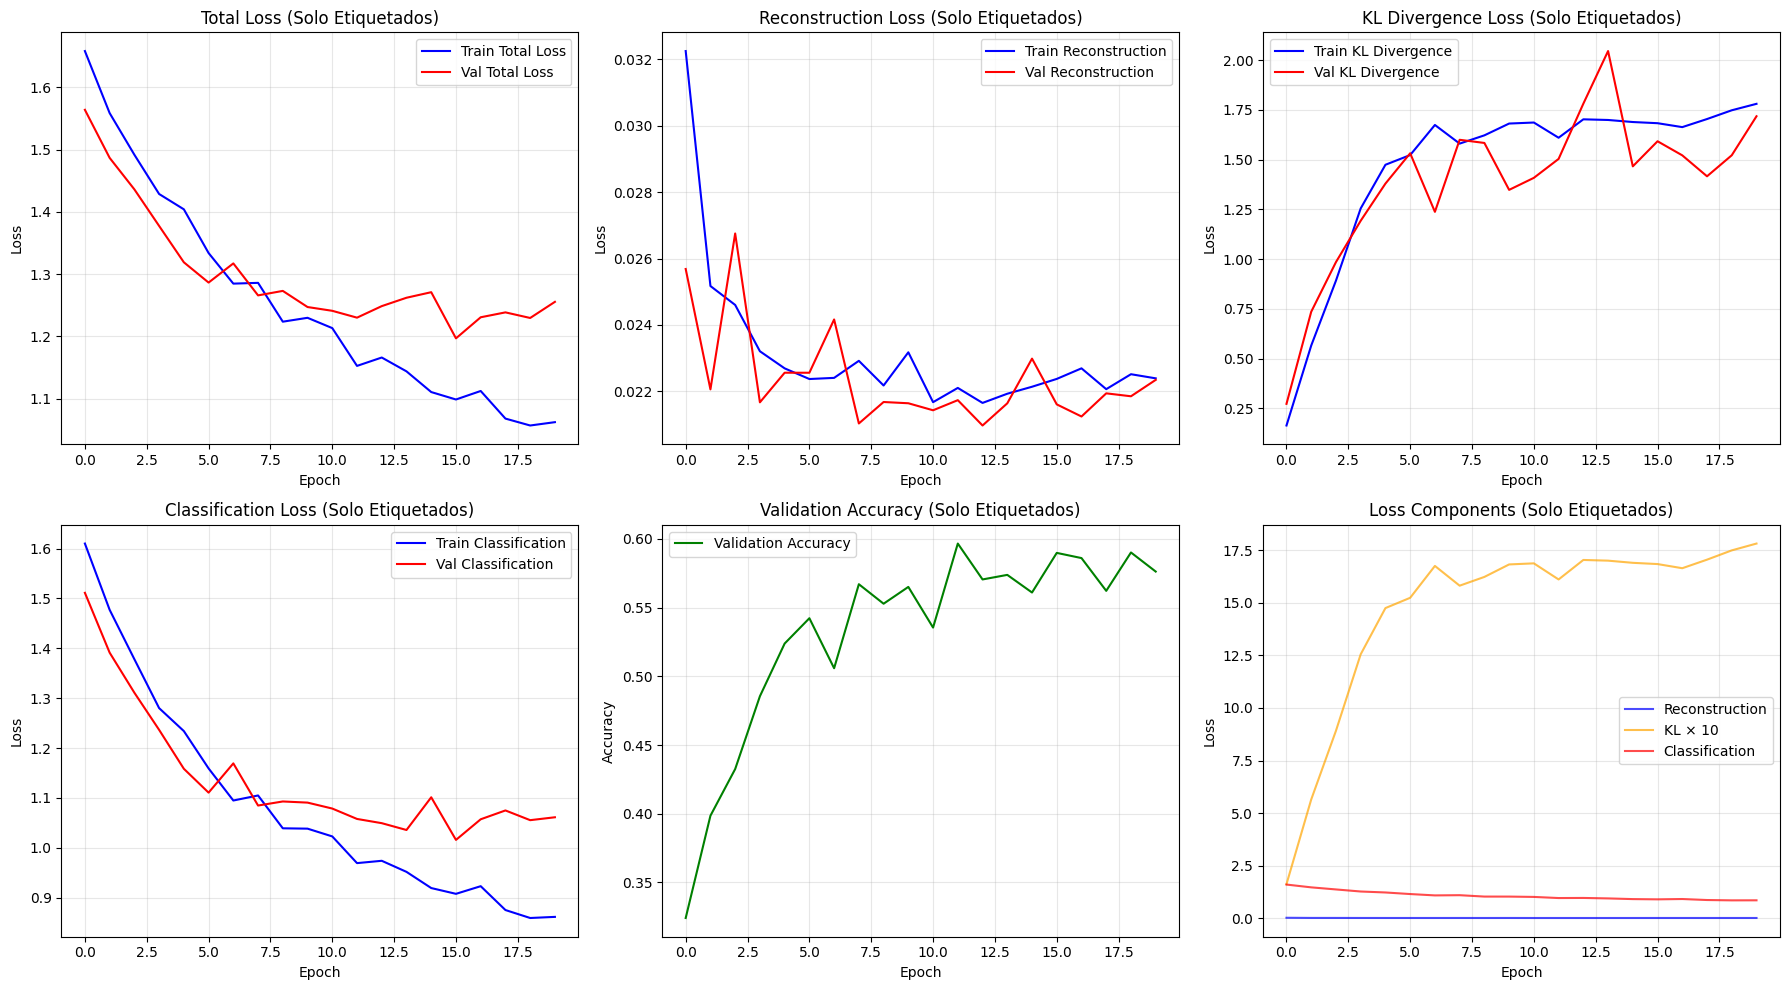

In [58]:
# Graficar las pérdidas y métricas para el modelo solo con datos etiquetados
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Pérdida total
axes[0, 0].plot(train_total_losses_labeled, label='Train Total Loss', color='blue')
axes[0, 0].plot(val_total_losses_labeled, label='Val Total Loss', color='red')
axes[0, 0].set_title('Total Loss (Solo Etiquetados)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Pérdida de reconstrucción
axes[0, 1].plot(train_recon_losses_labeled, label='Train Reconstruction', color='blue')
axes[0, 1].plot(val_recon_losses_labeled, label='Val Reconstruction', color='red')
axes[0, 1].set_title('Reconstruction Loss (Solo Etiquetados)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Pérdida KL
axes[0, 2].plot(train_kl_losses_labeled, label='Train KL Divergence', color='blue')
axes[0, 2].plot(val_kl_losses_labeled, label='Val KL Divergence', color='red')
axes[0, 2].set_title('KL Divergence Loss (Solo Etiquetados)')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Pérdida de clasificación
axes[1, 0].plot(train_class_losses_labeled, label='Train Classification', color='blue')
axes[1, 0].plot(val_class_losses_labeled, label='Val Classification', color='red')
axes[1, 0].set_title('Classification Loss (Solo Etiquetados)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy de validación
axes[1, 1].plot(val_accuracies_labeled, label='Validation Accuracy', color='green')
axes[1, 1].set_title('Validation Accuracy (Solo Etiquetados)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Comparación de pérdidas
axes[1, 2].plot(train_recon_losses_labeled, label='Reconstruction', color='blue', alpha=0.7)
axes[1, 2].plot([x*10 for x in train_kl_losses_labeled], label='KL × 10', color='orange', alpha=0.7)
axes[1, 2].plot(train_class_losses_labeled, label='Classification', color='red', alpha=0.7)
axes[1, 2].set_title('Loss Components (Solo Etiquetados)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

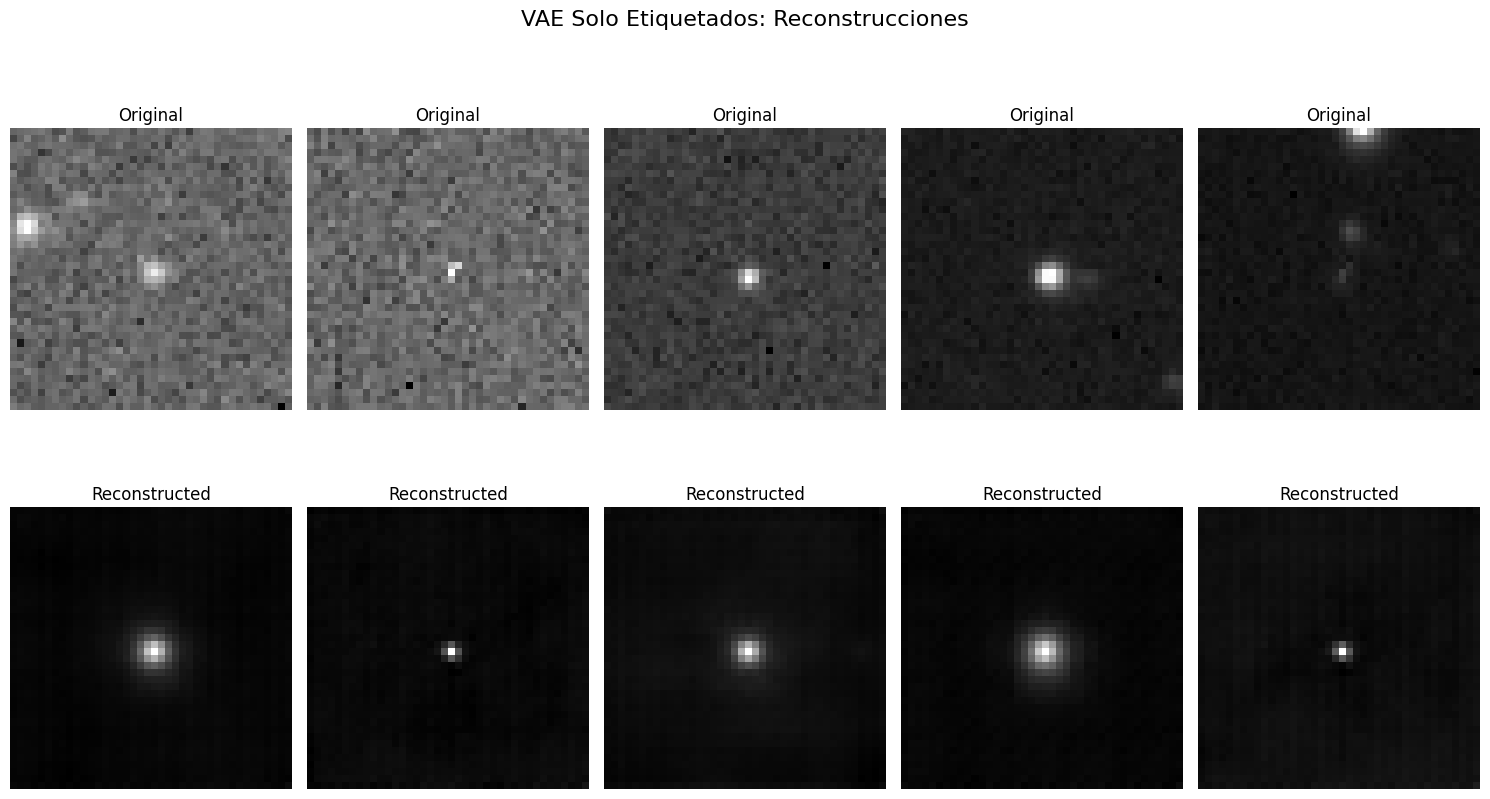

In [66]:
# Mostrar reconstrucciones del modelo solo con datos etiquetados
sample_indices = np.random.choice(len(X_val_labeled_clean), 5, replace=False)
samples = X_val_labeled_clean[sample_indices]
reconstructed, classifications, _, _ = ss_vae_labeled(samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 9))
for i in range(5):
    # Original
    axes[0, i].imshow(samples[i, :, :, 0], cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Reconstrucción
    axes[1, i].imshow(reconstructed[i, :, :, 0], cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.suptitle('VAE Solo Etiquetados: Reconstrucciones', fontsize=16)
plt.tight_layout()
plt.show()


In [67]:
X_all_labeled_clean = np.concatenate([X_train_labeled_clean, X_val_labeled_clean], axis=0)
y_all_labeled_clean = np.concatenate([y_train_labeled_clean, y_val_labeled_clean], axis=0)

# Obtener representaciones del modelo solo con datos etiquetados
z_mean_labeled, z_log_var_labeled, classifications_labeled = encode_semisupervised_in_batches(ss_vae_labeled, X_all_labeled_clean)

print("Aplicando UMAP al espacio latente del modelo solo con datos etiquetados...")
reducer_labeled = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_labeled = reducer_labeled.fit_transform(z_mean_labeled)

Procesado lote 50/115
Procesado lote 100/115
Procesado lote 115/115
Aplicando UMAP al espacio latente del modelo solo con datos etiquetados...


/home/benjamin/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/benjamin/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


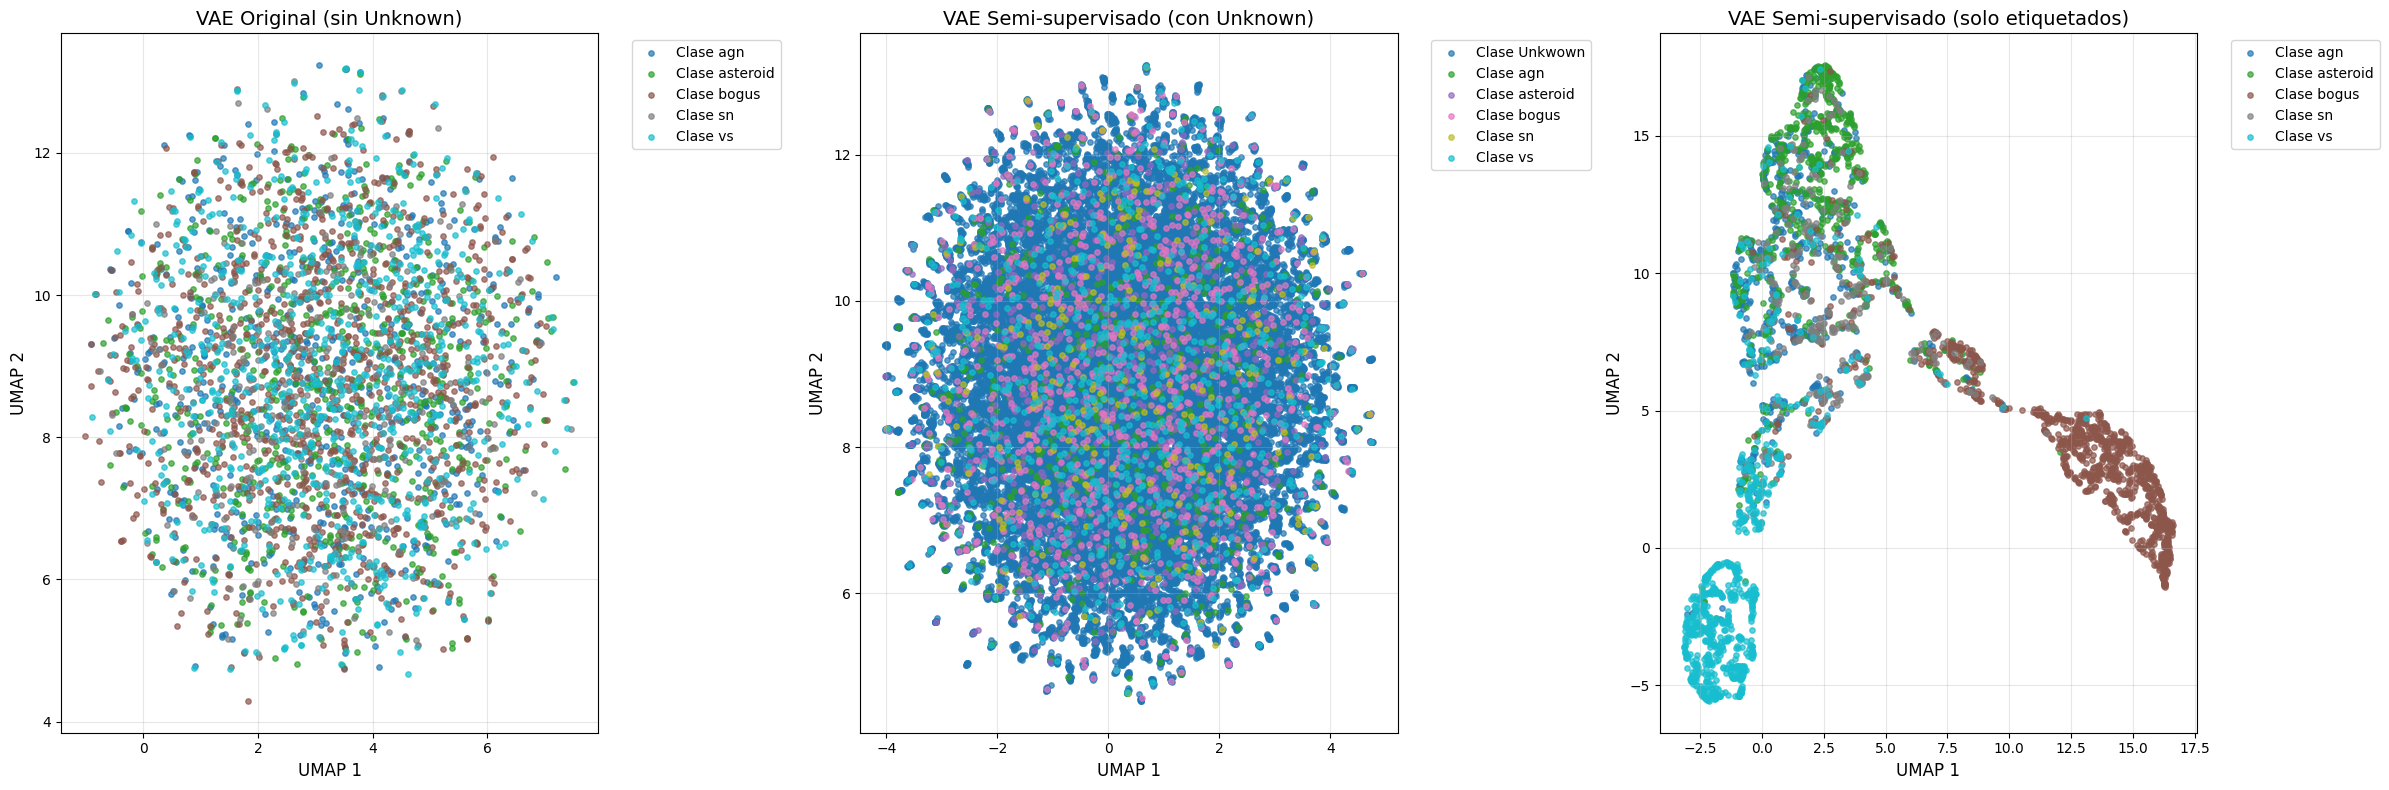

In [68]:
# Comparar todas las visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Colores para las clases (sin Unknown)
colors_labeled = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_all_labeled_clean))))

# VAE original (filtrar solo las clases que no son Unknown)
mask_not_unknown = y_all_clean != 'Unknown'
for i, cls in enumerate(sorted(np.unique(y_all_labeled_clean))):
    mask = (y_all_clean == cls) & mask_not_unknown
    if np.any(mask):
        axes[0].scatter(embedding[mask, 0], embedding[mask, 1], 
                       c=[colors_labeled[i]], label=f'Clase {cls}', alpha=0.7, s=15)

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].set_title('VAE Original (sin Unknown)', fontsize=14)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# VAE semi-supervisado (con Unknown)
colors_with_unknown = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_all_clean))))
for i, cls in enumerate(sorted(np.unique(y_all_clean))):
    mask = y_all_clean == cls
    axes[1].scatter(embedding_ss[mask, 0], embedding_ss[mask, 1], 
                   c=[colors_with_unknown[i]], label=f'Clase {cls}', alpha=0.7, s=15)

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].set_title('VAE Semi-supervisado (con Unknown)', fontsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

# VAE semi-supervisado solo con datos etiquetados
for i, cls in enumerate(sorted(np.unique(y_all_labeled_clean))):
    mask = y_all_labeled_clean == cls
    axes[2].scatter(embedding_labeled[mask, 0], embedding_labeled[mask, 1], 
                   c=[colors_labeled[i]], label=f'Clase {cls}', alpha=0.7, s=15)

axes[2].set_xlabel('UMAP 1', fontsize=12)
axes[2].set_ylabel('UMAP 2', fontsize=12)
axes[2].set_title('VAE Semi-supervisado (solo etiquetados)', fontsize=14)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Aqui ocurre todo lo contrario, las metricas son espectaculares y se pueden observar claramente las tendencias de las clases en el UMAP. Esto es, gracias a que quitamos la clase 'Unknown', que no hace mas que confundir el modelo, agregar costos de entrenamiento. Sin embargo, es importante tener un equilibrio con las samples "sin clase", ya que el modelo tambien debe aprender a identificar cuando un objeto no corresponde a ninguno de los que el fue enseñado a clasificar. Esto ultimo se logra con under sampling, pesos de clases y data augmentation en caso de necesitarlo para las clases mas escasas.
